#### Nullable integer data type
- **Note**: IntegerArray is currently experimental. Its API or implementation may change without warning. Uses pandas.NA as the missing value.
- In Working with missing data, we saw that pandas primarily uses NaN to represent missing data. Because NaN is a float, this forces an array of integers with any missing values to become floating point. In some cases, this may not matter much. But if your integer column is, say, an identifier, casting to float can be problematic. Some integers cannot even be represented as floating point numbers.

#### Construction
- pandas can represent integer data with possibly missing values using arrays.IntegerArray. This is an extension type implemented within pandas.

In [5]:
import pandas as pd
import numpy as np

In [3]:
arr = pd.array([1, 2, None], dtype=pd.Int64Dtype())
arr

<IntegerArray>
[1, 2, <NA>]
Length: 3, dtype: Int64

- Or the string alias "Int64" (note the capital "I") to differentiate from NumPy’s 'int64' dtype:



In [6]:
pd.array([1, 2, np.nan], dtype="Int64")

<IntegerArray>
[1, 2, <NA>]
Length: 3, dtype: Int64

- All NA-like values are replaced with pandas.NA.

In [7]:
pd.array([1, 2, np.nan, None, pd.NA], dtype="Int64")

<IntegerArray>
[1, 2, <NA>, <NA>, <NA>]
Length: 5, dtype: Int64

- This array can be stored in a DataFrame or Series like any NumPy array.

In [8]:
pd.Series(arr)

0       1
1       2
2    <NA>
dtype: Int64

- You can also pass the list-like object to the Series constructor with the dtype.
- **Warning**: Currently pandas.array() and pandas.Series() use different rules for dtype inference. pandas.array() will infer a nullable-integer dtype

In [9]:
pd.array([1, None])

<IntegerArray>
[1, <NA>]
Length: 2, dtype: Int64

In [10]:
pd.array([1, 2])

<IntegerArray>
[1, 2]
Length: 2, dtype: Int64

- For backwards-compatibility, Series infers these as either integer or float dtype.

In [11]:
pd.Series([1, None])

0    1.0
1    NaN
dtype: float64

In [12]:
pd.Series([1, 2])

0    1
1    2
dtype: int64

- We recommend explicitly providing the dtype to avoid confusion.

In [13]:
pd.array([1, None], dtype="Int64")

<IntegerArray>
[1, <NA>]
Length: 2, dtype: Int64

In [14]:
pd.Series([1, None], dtype="Int64")

0       1
1    <NA>
dtype: Int64

- In the future, we may provide an option for Series to infer a nullable-integer dtype.
#### Operations
- Operations involving an integer array will behave similar to NumPy arrays. Missing values will be propagated, and the data will be coerced to another dtype if needed.

In [16]:
s = pd.Series([1, 2, None], dtype="Int64")
# arithmetic
s + 1

0       2
1       3
2    <NA>
dtype: Int64

In [17]:
# comparison
s == 1

0     True
1    False
2     <NA>
dtype: boolean

In [18]:
# slicing operation
s.iloc[1:3]

1       2
2    <NA>
dtype: Int64

In [19]:
# operate with other dtypes
s + s.iloc[1:3].astype("Int8")

0    <NA>
1       4
2    <NA>
dtype: Int64

In [20]:

# coerce when needed
s + 0.01

0    1.01
1    2.01
2    <NA>
dtype: Float64

- These dtypes can operate as part of a DataFrame.

In [21]:
df = pd.DataFrame({"A": s, "B": [1, 1, 3], "C": list("aab")})
df

A  B  C
0     1  1  a
1     2  1  a
2  <NA>  3  b

In [22]:
df.dtypes

A     Int64
B     int64
C    object
dtype: object

- These dtypes can be merged, reshaped & casted.

In [23]:
pd.concat([df[["A"]], df[["B", "C"]]], axis=1).dtypes

A     Int64
B     int64
C    object
dtype: object

In [24]:
df["A"].astype(float)

0    1.0
1    2.0
2    NaN
Name: A, dtype: float64

- Reduction and groupby operations such as sum() work as well.

In [25]:
df.sum(numeric_only=True)

A    3
B    5
dtype: Int64

In [26]:
df.sum()

A      3
B      5
C    aab
dtype: object

In [27]:
df.groupby("B").A.sum()

B
1    3
3    0
Name: A, dtype: Int64

#### Scalar NA Value
- arrays.IntegerArray uses pandas.NA as its scalar missing value. Slicing a single element that’s missing will return pandas.NA

In [28]:
a = pd.array([1, None], dtype="Int64")
a[1]

<NA>

#### Nullable Boolean data type
- From https://pandas.pydata.org/docs/user_guide/boolean.html
- **Note**: BooleanArray is currently experimental. Its API or implementation may change without warning.
#### Indexing with NA values
- pandas allows indexing with NA values in a boolean array, which are treated as False.

In [29]:
s = pd.Series([1, 2, 3])
mask = pd.array([True, False, pd.NA], dtype="boolean")
s[mask]


0    1
dtype: int64

- If you would prefer to keep the NA values you can manually fill them with fillna(True).

In [30]:
s[mask.fillna(True)]

0    1
2    3
dtype: int64

#### Kleene logical operations
- arrays.BooleanArray implements Kleene Logic (sometimes called three-value logic) for logical operations like & (and), | (or) and ^ (exclusive-or).

- This table demonstrates the results for every combination. These operations are symmetrical, so flipping the left- and right-hand side makes no difference in the result.

| Expression | Result |
| ------- | ---- |
| True & True | True |
| True & False | False |
| True & NA | NA |
| False & False | False |
| False & NA | False |
| NA & NA | NA |
| True | True | True |
| True | False | True |
| True | NA | True |
| False | False | False |
| False | NA | NA |
| NA | NA | NA |
| True ^ True | False |
| True ^ False | True |
| True ^ NA | NA |
| False ^ False | False |
| False ^ NA | NA |
| NA ^ NA | NA |

- When an NA is present in an operation, the output value is NA only if the result cannot be determined solely based on the other input. For example, True | NA is True, because both True | True and True | False are True. In that case, we don’t actually need to consider the value of the NA.

- On the other hand, True & NA is NA. The result depends on whether the NA really is True or False, since True & True is True, but True & False is False, so we can’t determine the output.

- This differs from how np.nan behaves in logical operations. pandas treated np.nan is always false in the output.

- In or

In [31]:
pd.Series([True, False, np.nan], dtype="object") | True


0     True
1     True
2    False
dtype: bool

In [32]:
pd.Series([True, False, np.nan], dtype="boolean") | True


0    True
1    True
2    True
dtype: boolean

- In and

In [33]:
pd.Series([True, False, np.nan], dtype="object") & True

0     True
1    False
2    False
dtype: bool

In [34]:
pd.Series([True, False, np.nan], dtype="boolean") & True

0     True
1    False
2     <NA>
dtype: boolean

#### Chart visualization
- **Note**: The examples below assume that you’re using Jupyter.
- This section demonstrates visualization through charting. For information on visualization of tabular data please see the section on Table Visualization.

- We use the standard convention for referencing the matplotlib API:

In [36]:
import matplotlib.pyplot as plt
plt.close("all")

- We provide the basics in pandas to easily create decent looking plots. See the ecosystem page for visualization libraries that go beyond the basics documented here.
- **Note**: All calls to np.random are seeded with 123456.

#### Basic plotting: plot
- We will demonstrate the basics, see the cookbook for some advanced strategies.

- The plot method on Series and DataFrame is just a simple wrapper around plt.plot():

<Axes: >

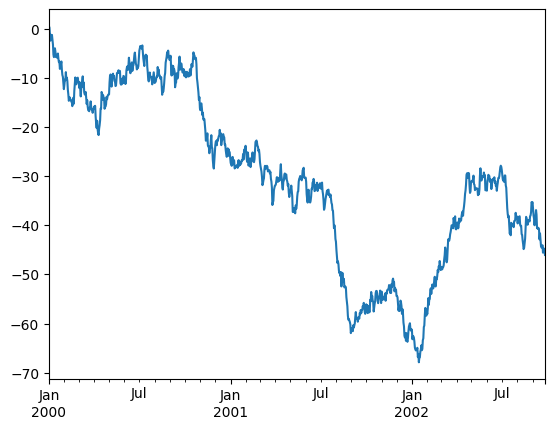

In [37]:
np.random.seed(123456)

ts = pd.Series(np.random.randn(1000), index=pd.date_range("1/1/2000", periods=1000))

ts = ts.cumsum()

ts.plot()

- If the index consists of dates, it calls gcf().autofmt_xdate() to try to format the x-axis nicely as per above.
- On DataFrame, plot() is a convenience to plot all of the columns with labels:

<Axes: >

<Figure size 640x480 with 0 Axes>

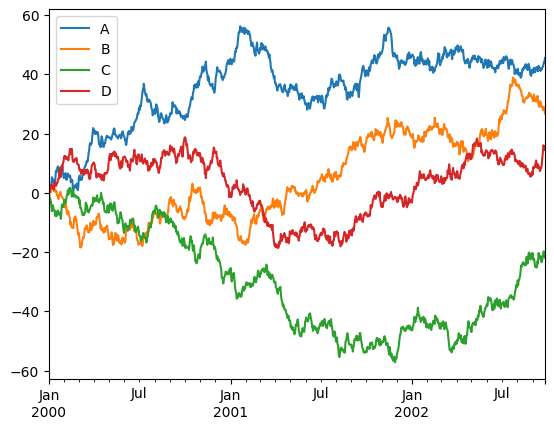

In [47]:
df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list("ABCD"))

df = df.cumsum()

plt.figure()

df.plot()

- You can plot one column versus another using the x and y keywords in plot():

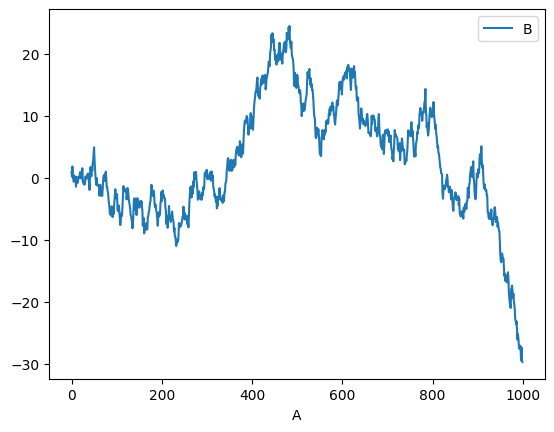

In [39]:
df3 = pd.DataFrame(np.random.randn(1000, 2), columns=["B", "C"]).cumsum()

df3["A"] = pd.Series(list(range(len(df))))

df3.plot(x="A", y="B");

- **Note**: For more formatting and styling options, see formatting below.
#### Other plots
- Plotting methods allow for a handful of plot styles other than the default line plot. These methods can be provided as the kind keyword argument to plot(), and include:
    - ‘bar’ or ‘barh’ for bar plots
    - ‘hist’ for histogram
    - ‘box’ for boxplot
    - ‘kde’ or ‘density’ for density plots
    - ‘area’ for area plots
    - ‘scatter’ for scatter plots
    - ‘hexbin’ for hexagonal bin plots
    - ‘pie’ for pie plots

- For example, a bar plot can be created the following way:

<Axes: >

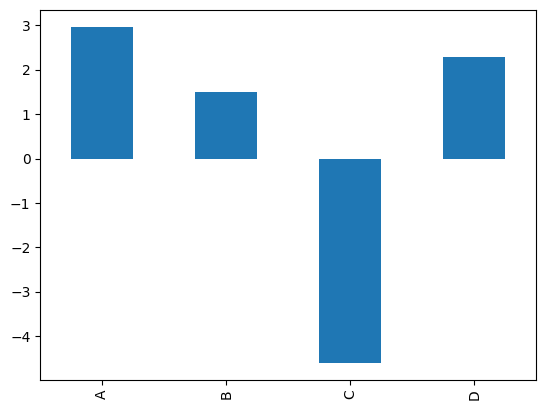

In [48]:
plt.figure()

df.iloc[5].plot(kind="bar")

- You can also create these other plots using the methods DataFrame.plot.<kind> instead of providing the kind keyword argument. This makes it easier to discover plot methods and the specific arguments they use:

In [49]:
# df = pd.DataFrame()

[name for name in dir(df.plot) if not name.startswith('__') and not name.startswith("_")] 

['area',
 'bar',
 'barh',
 'box',
 'density',
 'hexbin',
 'hist',
 'kde',
 'line',
 'pie',
 'scatter']

- In addition to these kind s, there are the DataFrame.hist(), and DataFrame.boxplot() methods, which use a separate interface.

- Finally, there are several plotting functions in pandas.plotting that take a Series or DataFrame as an argument. These include:
    - Scatter Matrix
    - Andrews Curves
    - Parallel Coordinates
    - Lag Plot
    - Autocorrelation Plot
    - Bootstrap Plot
    - RadViz

- Plots may also be adorned with errorbars or tables.

#### Bar plots
- For labeled, non-time series data, you may wish to produce a bar plot:

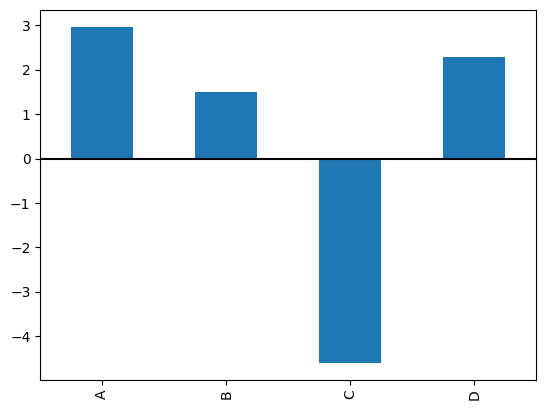

In [50]:
plt.figure()
df.iloc[5].plot.bar()
plt.axhline(0, color='k')

- Calling a DataFrame’s plot.bar() method produces a multiple bar plot:

<Axes: >

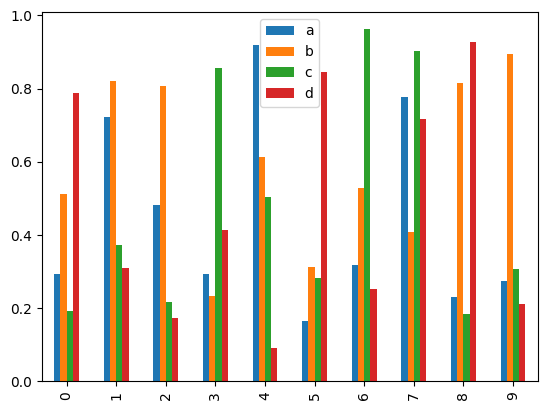

In [51]:
df2 = pd.DataFrame(np.random.rand(10, 4), columns=["a", "b", "c", "d"])

df2.plot.bar()

- To produce a stacked bar plot, pass stacked=True:

<Axes: >

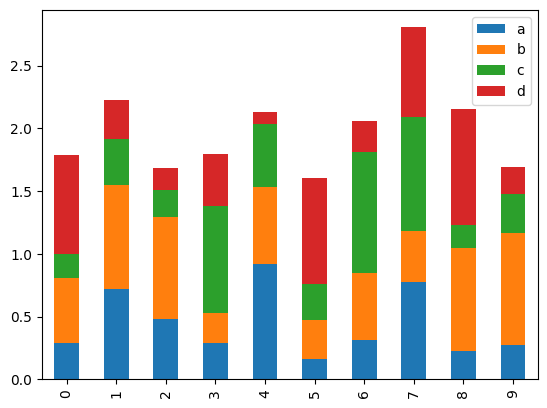

In [52]:
df2.plot.bar(stacked=True)

- To get horizontal bar plots, use the barh method:

<Axes: >

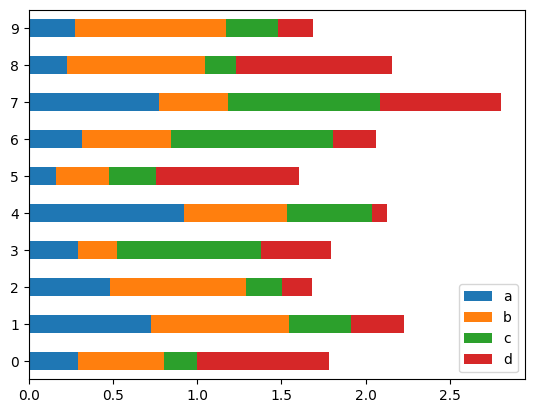

In [53]:
df2.plot.barh(stacked=True)

#### Histograms
- Histograms can be drawn by using the DataFrame.plot.hist() and Series.plot.hist() methods.

<Axes: ylabel='Frequency'>

<Figure size 640x480 with 0 Axes>

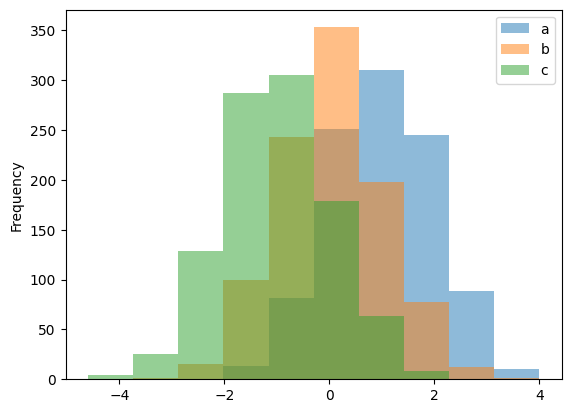

In [55]:
df4 = pd.DataFrame(
    {
        "a": np.random.randn(1000) + 1,
        "b": np.random.randn(1000),
        "c": np.random.randn(1000) - 1,
    },
    columns=["a", "b", "c"],
)

plt.figure()
df4.plot.hist(alpha=0.5)

- A histogram can be stacked using stacked=True. Bin size can be changed using the bins keyword.

<Figure size 640x480 with 0 Axes>

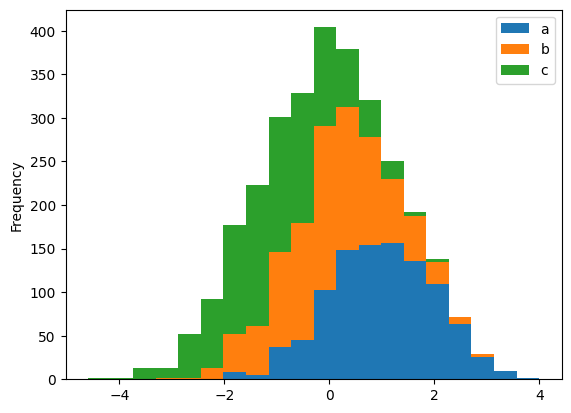

In [56]:
plt.figure();

df4.plot.hist(stacked=True, bins=20);

- You can pass other keywords supported by matplotlib hist. For example, horizontal and cumulative histograms can be drawn by orientation='horizontal' and cumulative=True.

<Axes: xlabel='Frequency'>

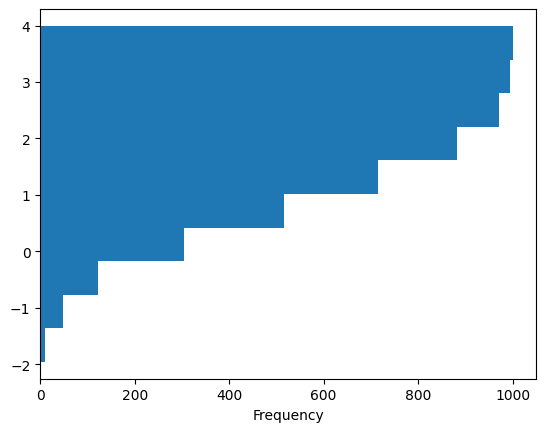

In [57]:
plt.figure()
df4["a"].plot.hist(orientation="horizontal", cumulative=True)

- The existing interface DataFrame.hist to plot histogram still can be used.

<Axes: >

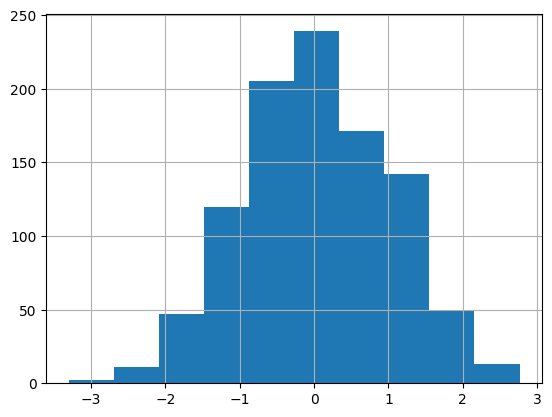

In [58]:
plt.figure()
df["A"].diff().hist()

- DataFrame.hist() plots the histograms of the columns on multiple subplots:

array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'B'}>],
       [<Axes: title={'center': 'C'}>, <Axes: title={'center': 'D'}>]],
      dtype=object)

<Figure size 640x480 with 0 Axes>

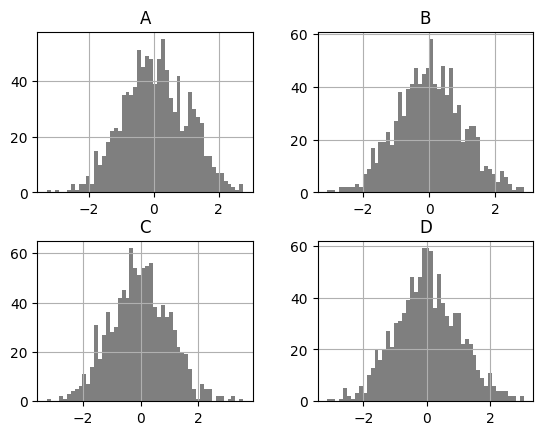

In [59]:
plt.figure()
df.diff().hist(color="k", alpha=0.5, bins=50)

- The by keyword can be specified to plot grouped histograms:

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>]],
      dtype=object)

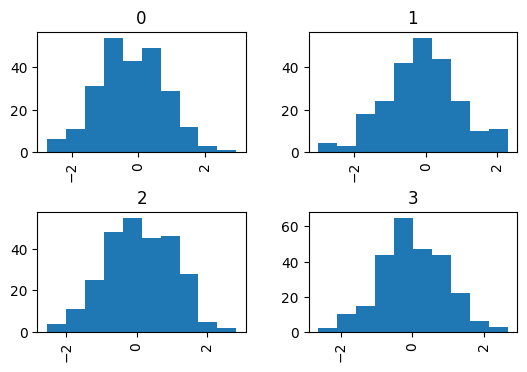

In [60]:
data = pd.Series(np.random.randn(1000))
data.hist(by=np.random.randint(0, 4, 1000), figsize=(6, 4))

- In addition, the by keyword can also be specified in DataFrame.plot.hist().

array([<Axes: title={'center': '(x, e)'}, ylabel='Frequency'>,
       <Axes: title={'center': '(x, f)'}, ylabel='Frequency'>,
       <Axes: title={'center': '(x, g)'}, ylabel='Frequency'>,
       <Axes: title={'center': '(y, e)'}, ylabel='Frequency'>,
       <Axes: title={'center': '(y, f)'}, ylabel='Frequency'>,
       <Axes: title={'center': '(y, g)'}, ylabel='Frequency'>,
       <Axes: title={'center': '(z, e)'}, ylabel='Frequency'>,
       <Axes: title={'center': '(z, f)'}, ylabel='Frequency'>,
       <Axes: title={'center': '(z, g)'}, ylabel='Frequency'>],
      dtype=object)

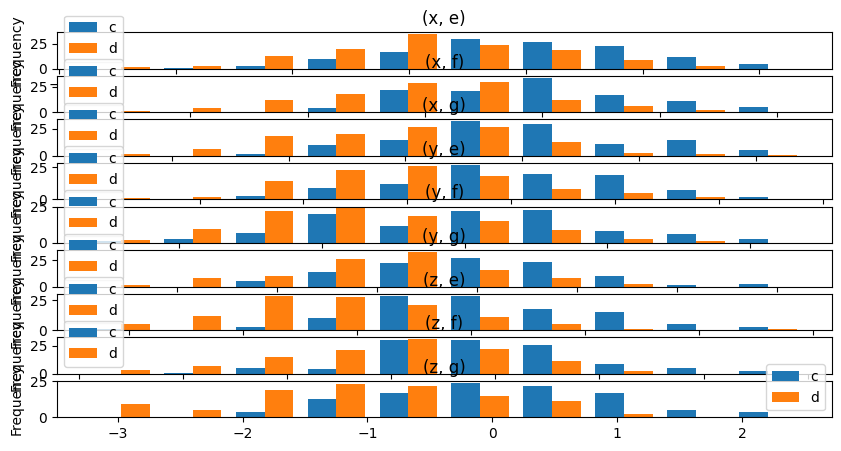

In [61]:
data = pd.DataFrame(
    {
        "a": np.random.choice(["x", "y", "z"], 1000),
        "b": np.random.choice(["e", "f", "g"], 1000),
        "c": np.random.randn(1000),
        "d": np.random.randn(1000) - 1,
    },
)
data.plot.hist(by=["a", "b"], figsize=(10, 5))

#### Box plots
- Boxplot can be drawn calling Series.plot.box() and DataFrame.plot.box(), or DataFrame.boxplot() to visualize the distribution of values within each column.

- For instance, here is a boxplot representing five trials of 10 observations of a uniform random variable on [0,1).

<Axes: >

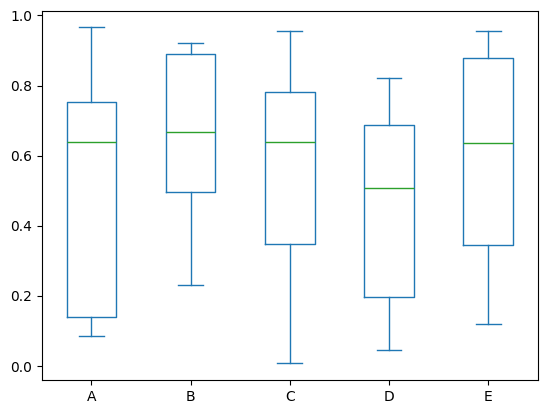

In [62]:
df = pd.DataFrame(np.random.rand(10, 5), columns=["A", "B", "C", "D", "E"])

df.plot.box()

- Boxplot can be colorized by passing color keyword. You can pass a dict whose keys are boxes, whiskers, medians and caps. If some keys are missing in the dict, default colors are used for the corresponding artists. Also, boxplot has sym keyword to specify fliers style.

- When you pass other type of arguments via color keyword, it will be directly passed to matplotlib for all the boxes, whiskers, medians and caps colorization.

- The colors are applied to every boxes to be drawn. If you want more complicated colorization, you can get each drawn artists by passing return_type.

<Axes: >

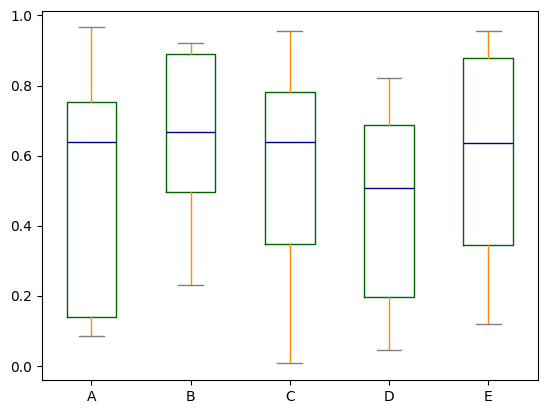

In [63]:
color = {
    "boxes": "DarkGreen",
    "whiskers": "DarkOrange",
    "medians": "DarkBlue",
    "caps": "Gray",
}
df.plot.box(color=color, sym="r+")


- Also, you can pass other keywords supported by matplotlib boxplot. For example, horizontal and custom-positioned boxplot can be drawn by vert=False and positions keywords.

<Axes: >

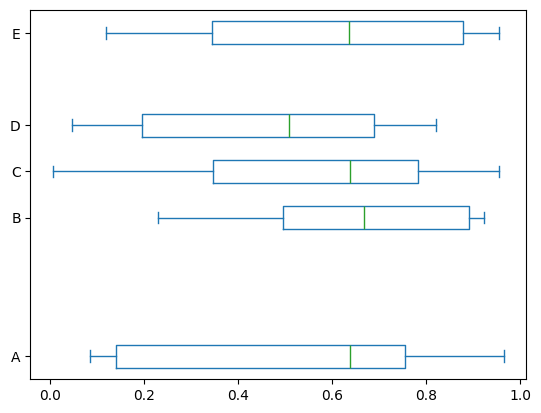

In [64]:
df.plot.box(vert=False, positions=[1, 4, 5, 6, 8])

- The existing interface DataFrame.boxplot to plot boxplot still can be used.

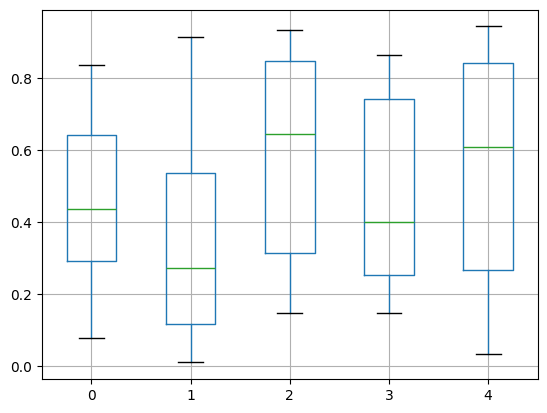

In [66]:
df = pd.DataFrame(np.random.rand(10, 5))
plt.figure()
bp = df.boxplot()

- You can create a stratified boxplot using the by keyword argument to create groupings. For instance,



<Figure size 640x480 with 0 Axes>

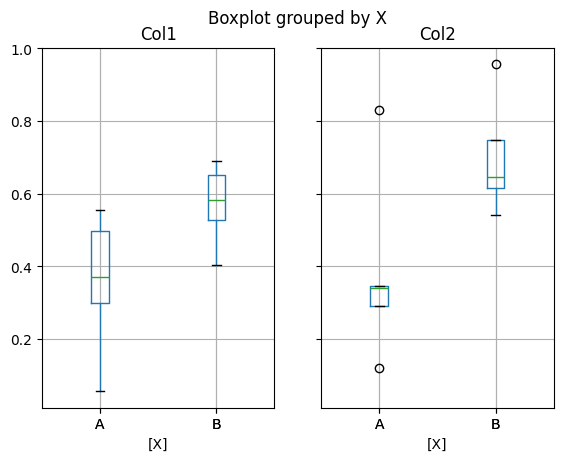

In [69]:
df = pd.DataFrame(np.random.rand(10, 2), columns=["Col1", "Col2"])
df["X"] = pd.Series(["A", "A", "A", "A", "A", "B", "B", "B", "B", "B"])
plt.figure()
bp = df.boxplot(by="X")

- You can also pass a subset of columns to plot, as well as group by multiple columns:

<Figure size 640x480 with 0 Axes>

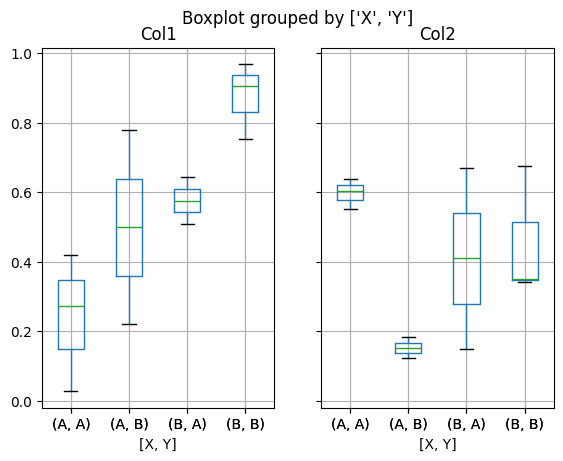

In [71]:
df = pd.DataFrame(np.random.rand(10, 3), columns=["Col1", "Col2", "Col3"])
df["X"] = pd.Series(["A", "A", "A", "A", "A", "B", "B", "B", "B", "B"])
df["Y"] = pd.Series(["A", "B", "A", "B", "A", "B", "A", "B", "A", "B"])
plt.figure()
bp = df.boxplot(column=["Col1", "Col2"], by=["X", "Y"])



- You could also create groupings with DataFrame.plot.box(), for instance:

<Figure size 640x480 with 0 Axes>

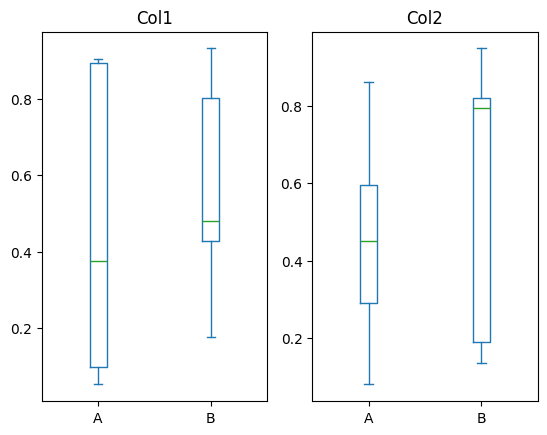

In [72]:
df = pd.DataFrame(np.random.rand(10, 3), columns=["Col1", "Col2", "Col3"])
df["X"] = pd.Series(["A", "A", "A", "A", "A", "B", "B", "B", "B", "B"])
plt.figure()
bp = df.plot.box(column=["Col1", "Col2"], by="X")

- In boxplot, the return type can be controlled by the return_type, keyword. The valid choices are {"axes", "dict", "both", None}. Faceting, created by DataFrame.boxplot with the by keyword, will affect the output type as well:

| return_type | Faceted | Output type |
| -------- | ------- | ---------- |
| None | No | axes |
| None | Yes | 2-D ndarray of axes |
| 'axes' | No | axes |
| 'axes' | Yes | Series of axes |
| 'dict' | No | dict of artists |
| 'dict' | Yes | Series of dicts of artists |
| 'both' | No | namedtuple |
| 'both' | Yes | Series of namedtuples |
- Groupby.boxplot always returns a Series of return_type.

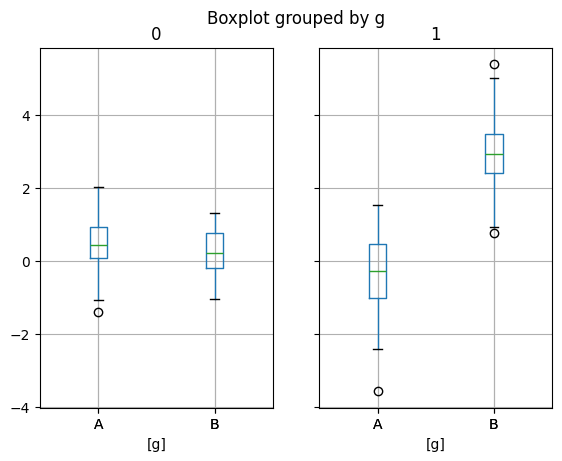

In [73]:
np.random.seed(1234)
df_box = pd.DataFrame(np.random.randn(50, 2))
df_box["g"] = np.random.choice(["A", "B"], size=50)
df_box.loc[df_box["g"] == "B", 1] += 3
bp = df_box.boxplot(by="g")

- The subplots above are split by the numeric columns first, then the value of the g column. Below the subplots are first split by the value of g, then by the numeric columns.

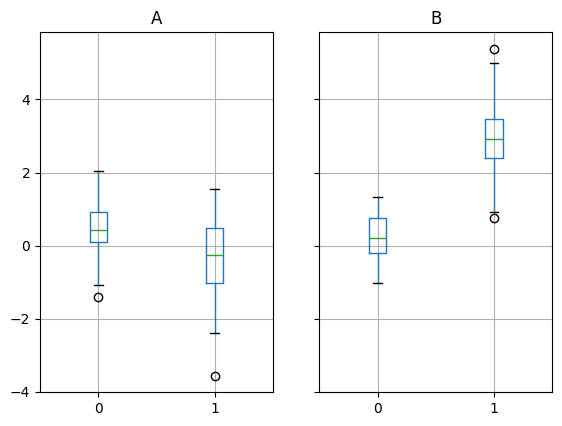

In [74]:
bp = df_box.groupby("g").boxplot()

#### Area plot
- You can create area plots with Series.plot.area() and DataFrame.plot.area(). Area plots are stacked by default. To produce stacked area plot, each column must be either all positive or all negative values.

- When input data contains NaN, it will be automatically filled by 0. If you want to drop or fill by different values, use dataframe.dropna() or dataframe.fillna() before calling plot.

<Axes: >

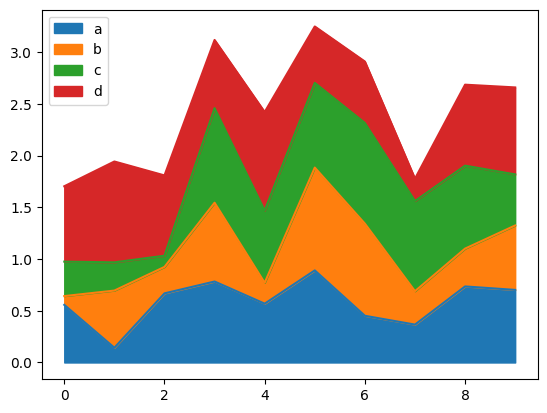

In [75]:
df = pd.DataFrame(np.random.rand(10, 4), columns=["a", "b", "c", "d"])
df.plot.area()

- To produce an unstacked plot, pass stacked=False. Alpha value is set to 0.5 unless otherwise specified:

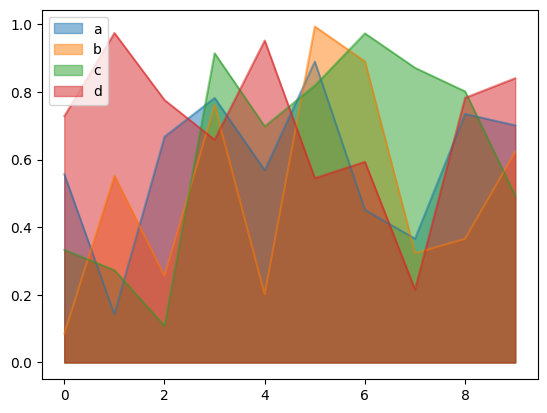

In [76]:
df.plot.area(stacked=False);

#### Scatter plot
- Scatter plot can be drawn by using the DataFrame.plot.scatter() method. Scatter plot requires numeric columns for the x and y axes. These can be specified by the x and y keywords.

<Axes: xlabel='a', ylabel='b'>

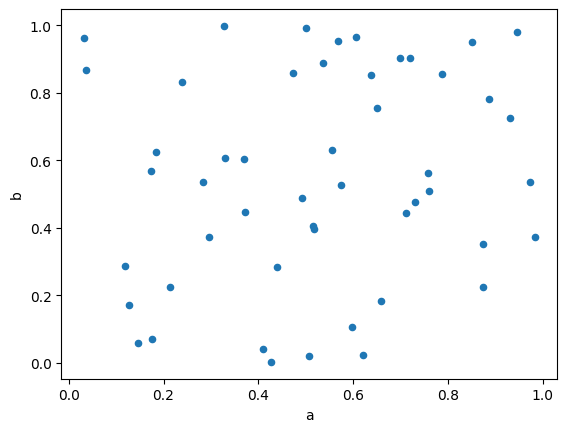

In [77]:
df = pd.DataFrame(np.random.rand(50, 4), columns=["a", "b", "c", "d"])
df["species"] = pd.Categorical(
    ["setosa"] * 20 + ["versicolor"] * 20 + ["virginica"] * 10
)
df.plot.scatter(x="a", y="b")

- To plot multiple column groups in a single axes, repeat plot method specifying target ax. It is recommended to specify color and label keywords to distinguish each groups.

<Axes: xlabel='c', ylabel='d'>

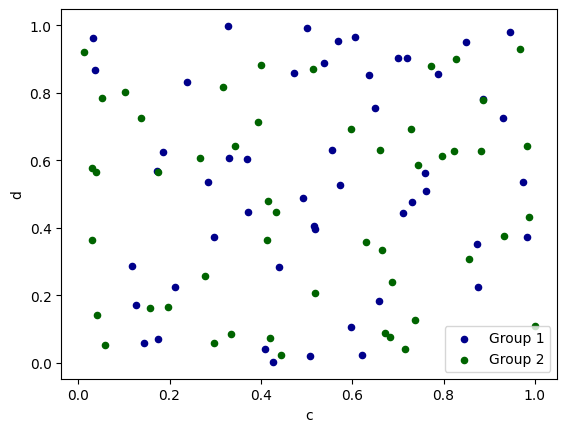

In [78]:
ax = df.plot.scatter(x="a", y="b", color="DarkBlue", label="Group 1")
df.plot.scatter(x="c", y="d", color="DarkGreen", label="Group 2", ax=ax)

- The keyword c may be given as the name of a column to provide colors for each point:

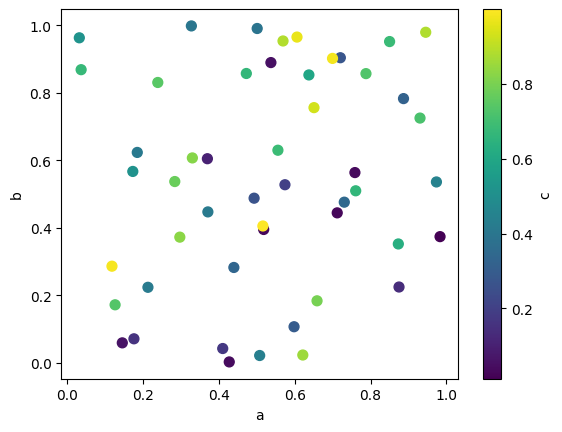

In [79]:
df.plot.scatter(x="a", y="b", c="c", s=50);

- If a categorical column is passed to c, then a discrete colorbar will be produced:

<Axes: xlabel='a', ylabel='b'>

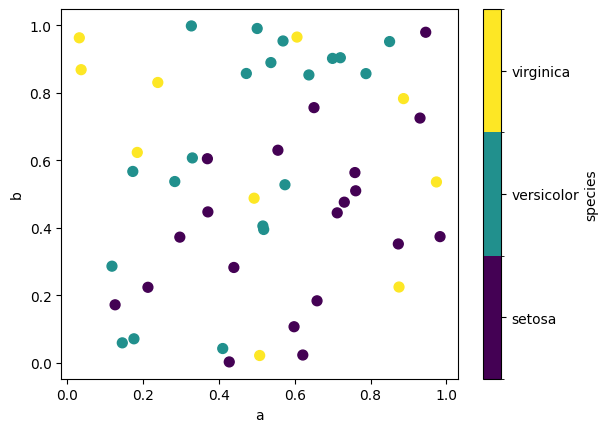

In [80]:
df.plot.scatter(x="a", y="b", c="species", cmap="viridis", s=50)

- You can pass other keywords supported by matplotlib scatter. The example below shows a bubble chart using a column of the DataFrame as the bubble size.

<Axes: xlabel='a', ylabel='b'>

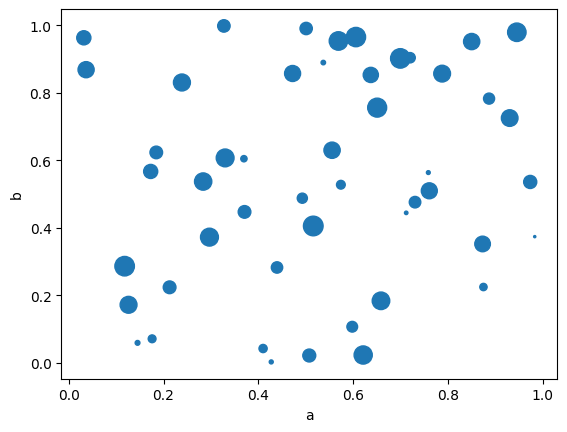

In [81]:
df.plot.scatter(x="a", y="b", s=df["c"] * 200)

#### Hexagonal bin plot
- You can create hexagonal bin plots with DataFrame.plot.hexbin(). Hexbin plots can be a useful alternative to scatter plots if your data are too dense to plot each point individually.

<Axes: xlabel='a', ylabel='b'>

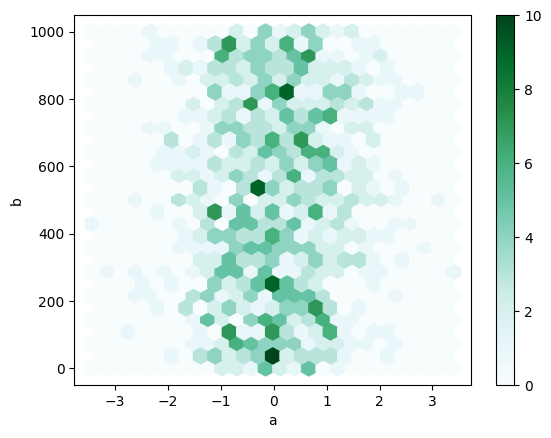

In [82]:
df = pd.DataFrame(np.random.randn(1000, 2), columns=["a", "b"])

df["b"] = df["b"] + np.arange(1000)
df.plot.hexbin(x="a", y="b", gridsize=25)

- A useful keyword argument is gridsize; it controls the number of hexagons in the x-direction, and defaults to 100. A larger gridsize means more, smaller bins.

- By default, a histogram of the counts around each (x, y) point is computed. You can specify alternative aggregations by passing values to the C and reduce_C_function arguments. C specifies the value at each (x, y) point and reduce_C_function is a function of one argument that reduces all the values in a bin to a single number (e.g. mean, max, sum, std). In this example the positions are given by columns a and b, while the value is given by column z. The bins are aggregated with NumPy’s max function.

<Axes: xlabel='a', ylabel='b'>

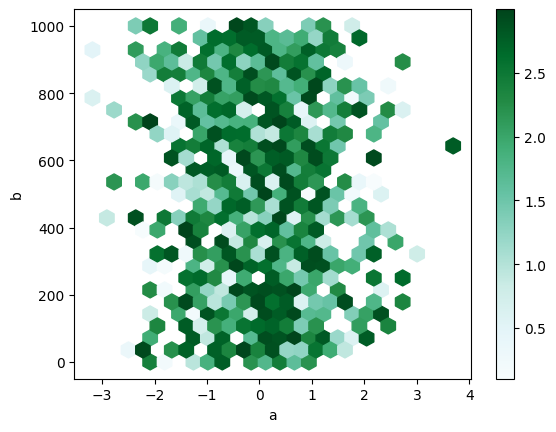

In [83]:
df = pd.DataFrame(np.random.randn(1000, 2), columns=["a", "b"])
df["b"] = df["b"] + np.arange(1000)
df["z"] = np.random.uniform(0, 3, 1000)
df.plot.hexbin(x="a", y="b", C="z", reduce_C_function=np.max, gridsize=25)

#### Pie plot
- You can create a pie plot with DataFrame.plot.pie() or Series.plot.pie(). If your data includes any NaN, they will be automatically filled with 0. A ValueError will be raised if there are any negative values in your data.

<Axes: ylabel='series'>

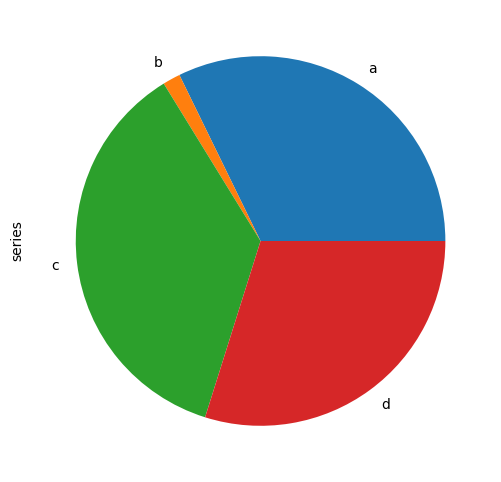

In [84]:
series = pd.Series(3 * np.random.rand(4), index=["a", "b", "c", "d"], name="series")
series.plot.pie(figsize=(6, 6))

- For pie plots it’s best to use square figures, i.e. a figure aspect ratio 1. You can create the figure with equal width and height, or force the aspect ratio to be equal after plotting by calling ax.set_aspect('equal') on the returned axes object.

- Note that pie plot with DataFrame requires that you either specify a target column by the y argument or subplots=True. When y is specified, pie plot of selected column will be drawn. If subplots=True is specified, pie plots for each column are drawn as subplots. A legend will be drawn in each pie plots by default; specify legend=False to hide it.

array([<Axes: ylabel='x'>, <Axes: ylabel='y'>], dtype=object)

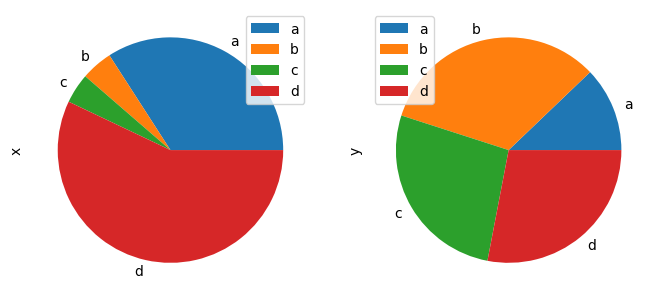

In [85]:
df = pd.DataFrame(
    3 * np.random.rand(4, 2), index=["a", "b", "c", "d"], columns=["x", "y"]
)
df.plot.pie(subplots=True, figsize=(8, 4))

- You can use the labels and colors keywords to specify the labels and colors of each wedge.
- **Warning**: Most pandas plots use the label and color arguments (note the lack of “s” on those). To be consistent with matplotlib.pyplot.pie() you must use labels and colors.
- If you want to hide wedge labels, specify labels=None. If fontsize is specified, the value will be applied to wedge labels. Also, other keywords supported by matplotlib.pyplot.pie() can be used.

<Axes: ylabel='series'>

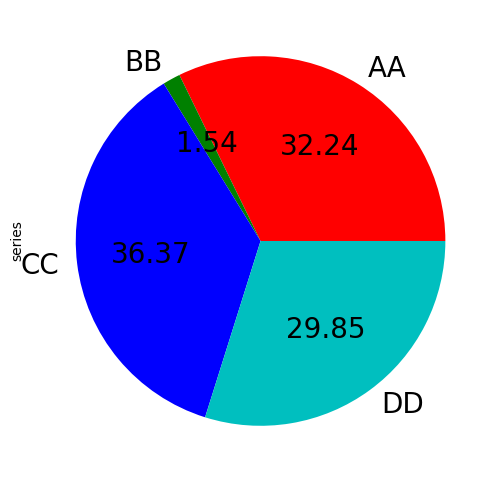

In [86]:
series.plot.pie(
    labels=["AA", "BB", "CC", "DD"],
    colors=["r", "g", "b", "c"],
    autopct="%.2f",
    fontsize=20,
    figsize=(6, 6),
)

- If you pass values whose sum total is less than 1.0 they will be rescaled so that they sum to 1.

<Axes: ylabel='series2'>

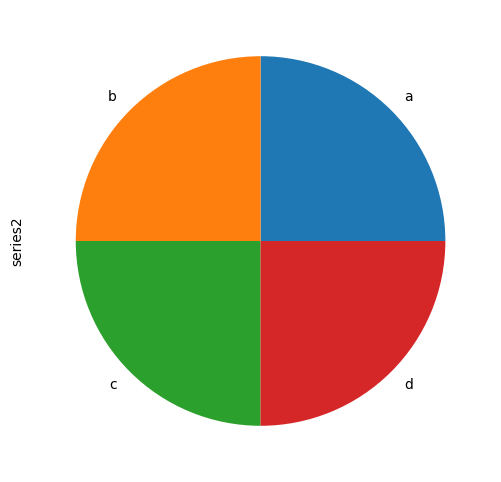

In [87]:
series = pd.Series([0.1] * 4, index=["a", "b", "c", "d"], name="series2")
series.plot.pie(figsize=(6, 6))

#### Plotting with missing data
- pandas tries to be pragmatic about plotting DataFrames or Series that contain missing data. Missing values are dropped, left out, or filled depending on the plot type.

| Plot Type | NaN Handling |
| --------- | ------------- |
| Line | Leave gaps at NaNs |
| Line (stacked) | Fill 0’s |
| Bar | Fill 0’s |
| Scatter | Drop NaNs |
| Histogram | Drop NaNs (column-wise) |
| Box | Drop NaNs (column-wise) |
| Area | Fill 0’s |
| KDE | Drop NaNs (column-wise) |
| Hexbin | Drop NaNs |
| Pie | Fill 0’s |

- If any of these defaults are not what you want, or if you want to be explicit about how missing values are handled, consider using fillna() or dropna() before plotting.

#### Plotting tools
- These functions can be imported from pandas.plotting and take a Series or DataFrame as an argument.

#### Scatter matrix plot
- You can create a scatter plot matrix using the scatter_matrix method in pandas.plotting:

array([[<Axes: xlabel='a', ylabel='a'>, <Axes: xlabel='b', ylabel='a'>,
        <Axes: xlabel='c', ylabel='a'>, <Axes: xlabel='d', ylabel='a'>],
       [<Axes: xlabel='a', ylabel='b'>, <Axes: xlabel='b', ylabel='b'>,
        <Axes: xlabel='c', ylabel='b'>, <Axes: xlabel='d', ylabel='b'>],
       [<Axes: xlabel='a', ylabel='c'>, <Axes: xlabel='b', ylabel='c'>,
        <Axes: xlabel='c', ylabel='c'>, <Axes: xlabel='d', ylabel='c'>],
       [<Axes: xlabel='a', ylabel='d'>, <Axes: xlabel='b', ylabel='d'>,
        <Axes: xlabel='c', ylabel='d'>, <Axes: xlabel='d', ylabel='d'>]],
      dtype=object)

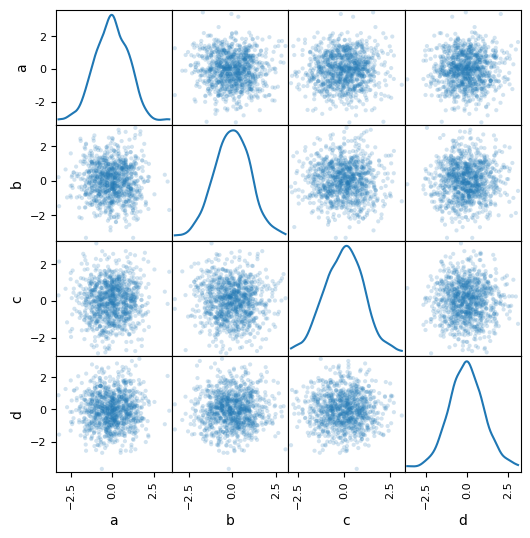

In [88]:
from pandas.plotting import scatter_matrix

df = pd.DataFrame(np.random.randn(1000, 4), columns=["a", "b", "c", "d"])
scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal="kde")

#### Density plot
- You can create density plots using the Series.plot.kde() and DataFrame.plot.kde() methods.

<Axes: ylabel='Density'>

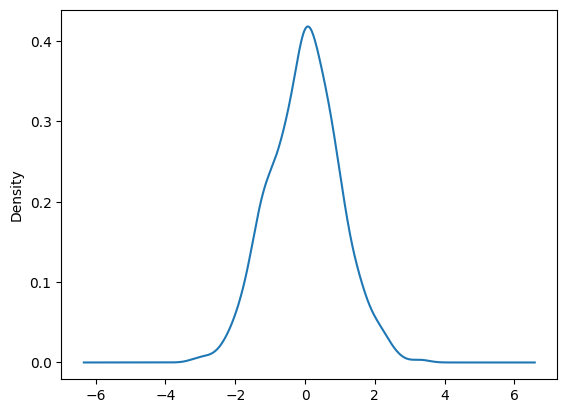

In [89]:
ser = pd.Series(np.random.randn(1000))
ser.plot.kde()

#### Andrews curves
- Andrews curves allow one to plot multivariate data as a large number of curves that are created using the attributes of samples as coefficients for Fourier series, see the Wikipedia entry for more information. By coloring these curves differently for each class it is possible to visualize data clustering. Curves belonging to samples of the same class will usually be closer together and form larger structures.

<Axes: >

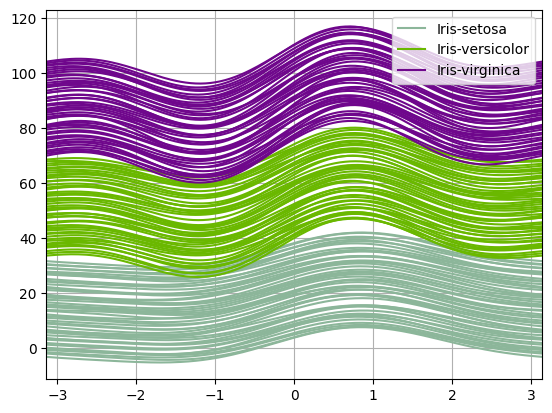

In [91]:
from pandas.plotting import andrews_curves

data = pd.read_csv("data/iris.csv")
plt.figure()

andrews_curves(data, "Name")

#### Parallel coordinates
- Parallel coordinates is a plotting technique for plotting multivariate data, see the Wikipedia entry for an introduction. Parallel coordinates allows one to see clusters in data and to estimate other statistics visually. Using parallel coordinates points are represented as connected line segments. Each vertical line represents one attribute. One set of connected line segments represents one data point. Points that tend to cluster will appear closer together.

<Axes: >

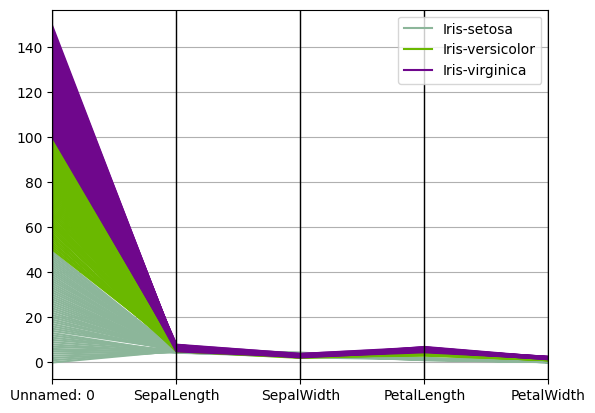

In [92]:
from pandas.plotting import parallel_coordinates

data = pd.read_csv("data/iris.csv")

plt.figure()

parallel_coordinates(data, "Name")

#### Lag plot
- Lag plots are used to check if a data set or time series is random. Random data should not exhibit any structure in the lag plot. Non-random structure implies that the underlying data are not random. The lag argument may be passed, and when lag=1 the plot is essentially data[:-1] vs. data[1:].

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

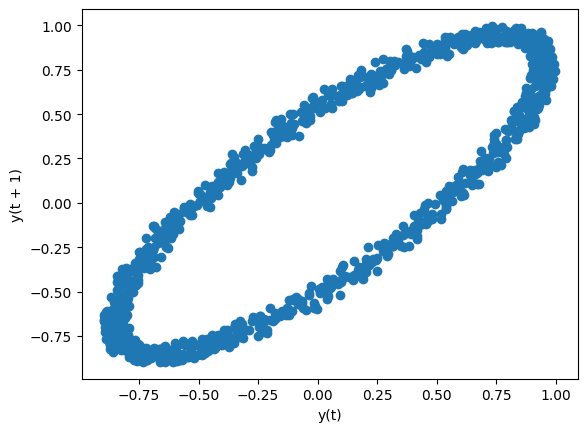

In [93]:
from pandas.plotting import lag_plot

plt.figure()
spacing = np.linspace(-99 * np.pi, 99 * np.pi, num=1000)
data = pd.Series(0.1 * np.random.rand(1000) + 0.9 * np.sin(spacing))
lag_plot(data)

#### Autocorrelation plot
- Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band. See the Wikipedia entry for more about autocorrelation plots.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

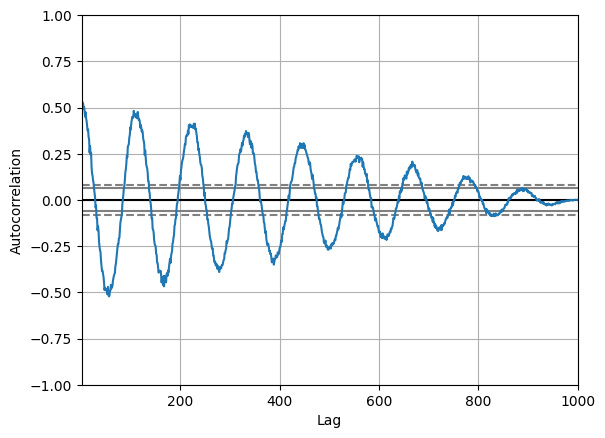

In [94]:
from pandas.plotting import autocorrelation_plot

plt.figure()
spacing = np.linspace(-9 * np.pi, 9 * np.pi, num=1000)
data = pd.Series(0.7 * np.random.rand(1000) + 0.3 * np.sin(spacing))
autocorrelation_plot(data)

#### Bootstrap plot
- Bootstrap plots are used to visually assess the uncertainty of a statistic, such as mean, median, midrange, etc. A random subset of a specified size is selected from a data set, the statistic in question is computed for this subset and the process is repeated a specified number of times. Resulting plots and histograms are what constitutes the bootstrap plot.

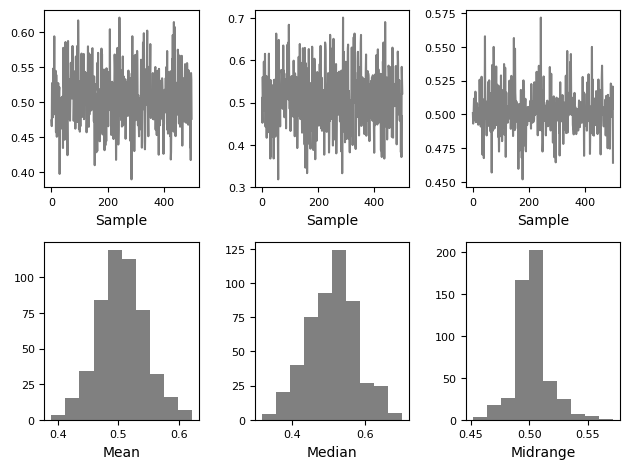

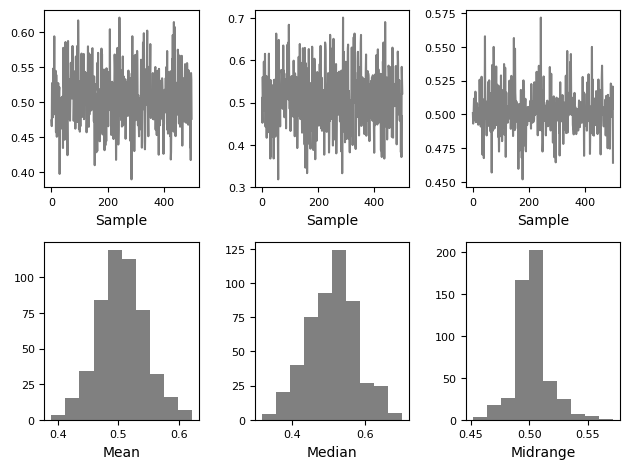

In [95]:
from pandas.plotting import bootstrap_plot
data = pd.Series(np.random.rand(1000))
bootstrap_plot(data, size=50, samples=500, color="grey")


#### RadViz
- RadViz is a way of visualizing multi-variate data. It is based on a simple spring tension minimization algorithm. Basically you set up a bunch of points in a plane. In our case they are equally spaced on a unit circle. Each point represents a single attribute. You then pretend that each sample in the data set is attached to each of these points by a spring, the stiffness of which is proportional to the numerical value of that attribute (they are normalized to unit interval). The point in the plane, where our sample settles to (where the forces acting on our sample are at an equilibrium) is where a dot representing our sample will be drawn. Depending on which class that sample belongs it will be colored differently. See the R package Radviz for more information.

<Axes: >

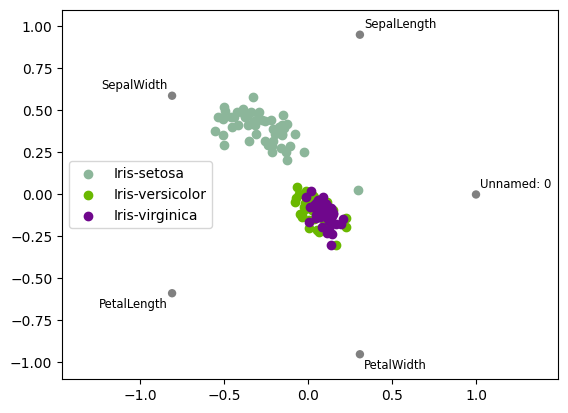

In [96]:
from pandas.plotting import radviz

data = pd.read_csv("data/iris.csv")

plt.figure()
radviz(data, "Name")

### Plot formatting
#### Setting the plot style
- From version 1.5 and up, matplotlib offers a range of pre-configured plotting styles. Setting the style can be used to easily give plots the general look that you want. Setting the style is as easy as calling matplotlib.style.use(my_plot_style) before creating your plot. For example you could write matplotlib.style.use('ggplot') for ggplot-style plots.

- You can see the various available style names at matplotlib.style.available and it’s very easy to try them out.

#### General plot style arguments
- Most plotting methods have a set of keyword arguments that control the layout and formatting of the returned plot:

<Axes: >

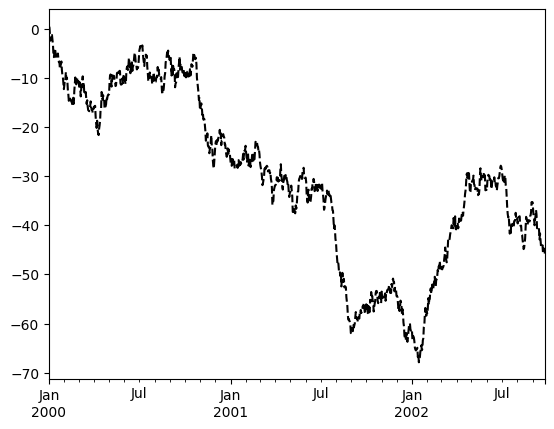

In [97]:
plt.figure()
ts.plot(style="k--", label="Series")

- For each kind of plot (e.g. line, bar, scatter) any additional arguments keywords are passed along to the corresponding matplotlib function (ax.plot(), ax.bar(), ax.scatter()). These can be used to control additional styling, beyond what pandas provides.

#### Controlling the legend
- You may set the legend argument to False to hide the legend, which is shown by default.

<Axes: >

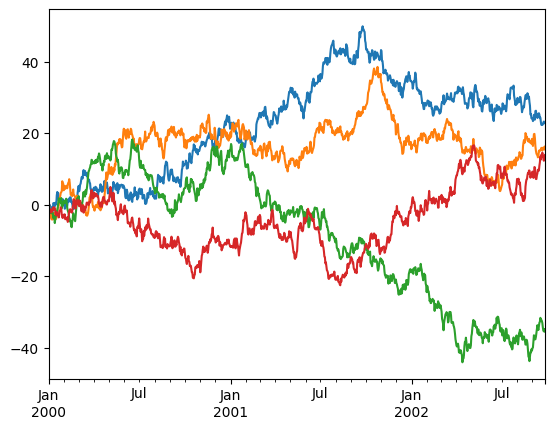

In [98]:
df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list("ABCD"))

df = df.cumsum()
df.plot(legend=False)

#### Controlling the labels
- You may set the xlabel and ylabel arguments to give the plot custom labels for x and y axis. By default, pandas will pick up index name as xlabel, while leaving it empty for ylabel.

<Axes: xlabel='new x', ylabel='new y'>

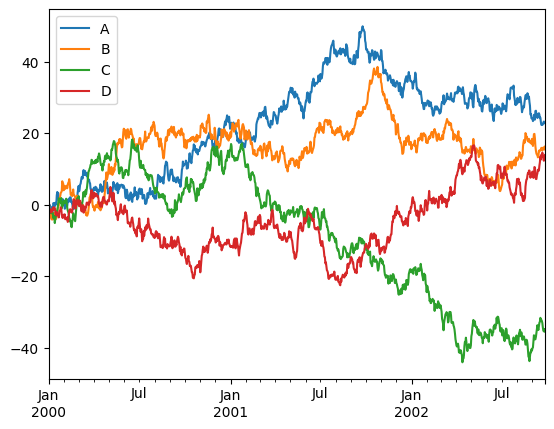

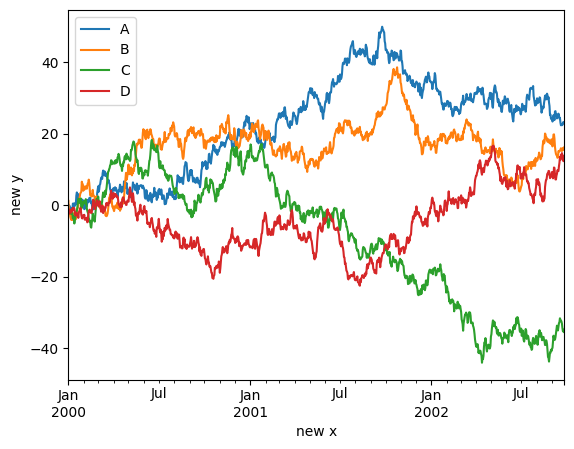

In [99]:
df.plot()
df.plot(xlabel="new x", ylabel="new y")

#### Scales
- You may pass logy to get a log-scale Y axis.

<Axes: >

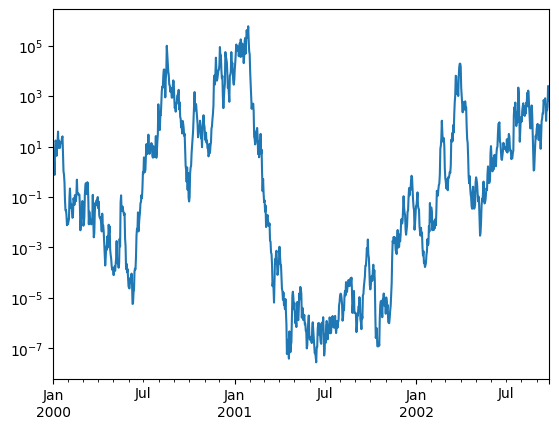

In [100]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range("1/1/2000", periods=1000))
ts = np.exp(ts.cumsum())
ts.plot(logy=True)

#### Plotting on a secondary y-axis
- To plot data on a secondary y-axis, use the secondary_y keyword:

<Axes: >

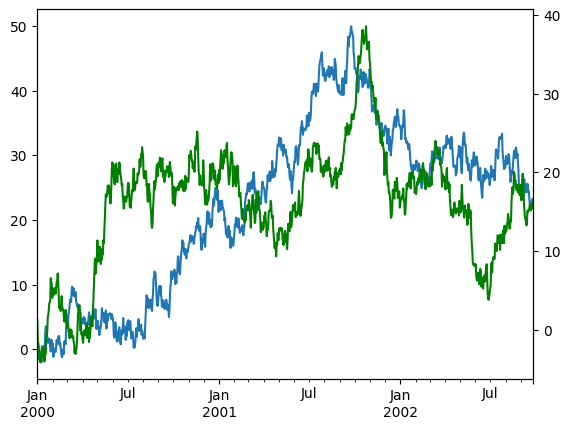

In [101]:
df["A"].plot()
df["B"].plot(secondary_y=True, style="g")

- To plot some columns in a DataFrame, give the column names to the secondary_y keyword:

Text(0, 0.5, 'AB scale')

<Figure size 640x480 with 0 Axes>

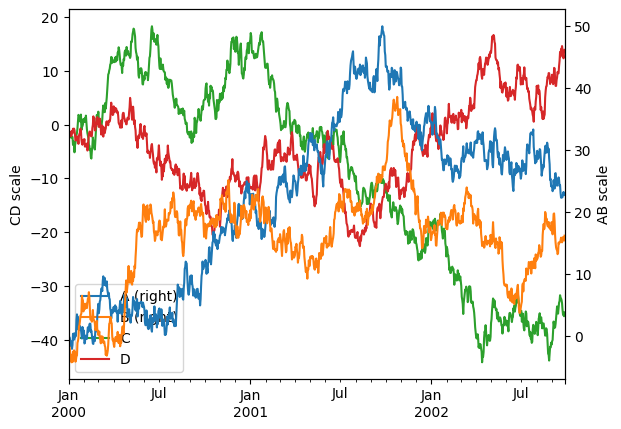

In [102]:
plt.figure()
ax = df.plot(secondary_y=["A", "B"])
ax.set_ylabel("CD scale")
ax.right_ax.set_ylabel("AB scale")

- Note that the columns plotted on the secondary y-axis is automatically marked with “(right)” in the legend. To turn off the automatic marking, use the mark_right=False keyword:

<Axes: >

<Figure size 640x480 with 0 Axes>

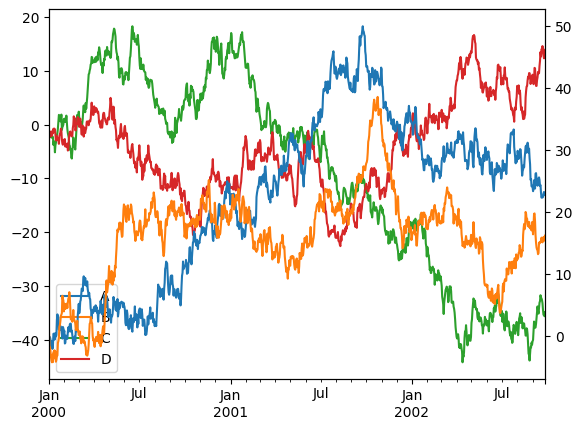

In [103]:
plt.figure()
df.plot(secondary_y=["A", "B"], mark_right=False)

#### Custom formatters for timeseries plots
- pandas provides custom formatters for timeseries plots. These change the formatting of the axis labels for dates and times. By default, the custom formatters are applied only to plots created by pandas with DataFrame.plot() or Series.plot(). To have them apply to all plots, including those made by matplotlib, set the option pd.options.plotting.matplotlib.register_converters = True or use pandas.plotting.register_matplotlib_converters().

#### Suppressing tick resolution adjustment
- pandas includes automatic tick resolution adjustment for regular frequency time-series data. For limited cases where pandas cannot infer the frequency information (e.g., in an externally created twinx), you can choose to suppress this behavior for alignment purposes.

- Here is the default behavior, notice how the x-axis tick labeling is performed:

<Axes: >

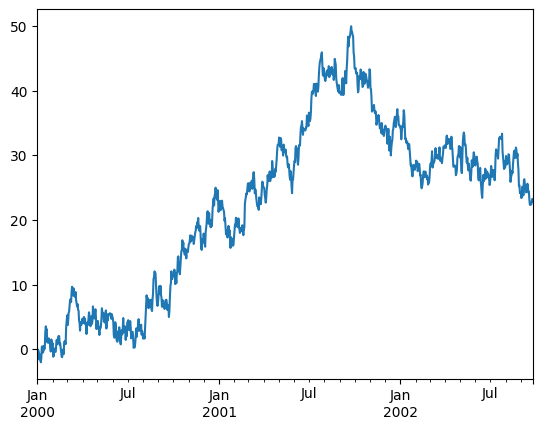

In [104]:
plt.figure()
df["A"].plot()

<Axes: >

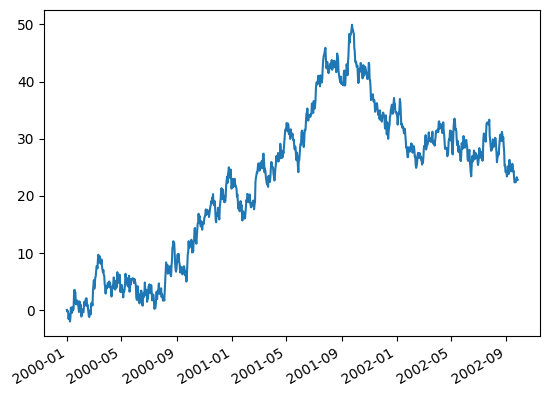

In [105]:
plt.figure()
df["A"].plot(x_compat=True)

- If you have more than one plot that needs to be suppressed, the use method in pandas.plotting.plot_params can be used in a with statement:

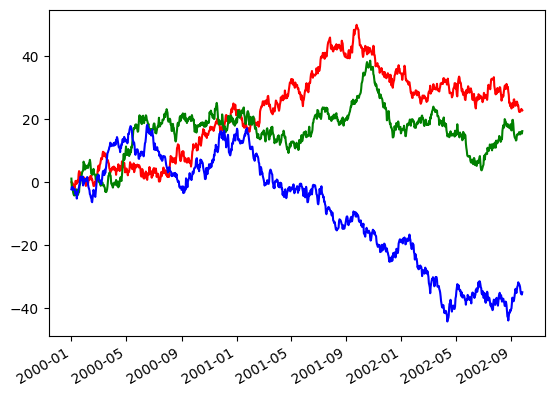

In [106]:
plt.figure()

with pd.plotting.plot_params.use("x_compat", True):
    df["A"].plot(color="r")
    df["B"].plot(color="g")
    df["C"].plot(color="b")

#### Automatic date tick adjustment
- TimedeltaIndex now uses the native matplotlib tick locator methods, it is useful to call the automatic date tick adjustment from matplotlib for figures whose ticklabels overlap.

- See the autofmt_xdate method and the matplotlib documentation for more.

#### Subplots
- Each Series in a DataFrame can be plotted on a different axis with the subplots keyword:

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

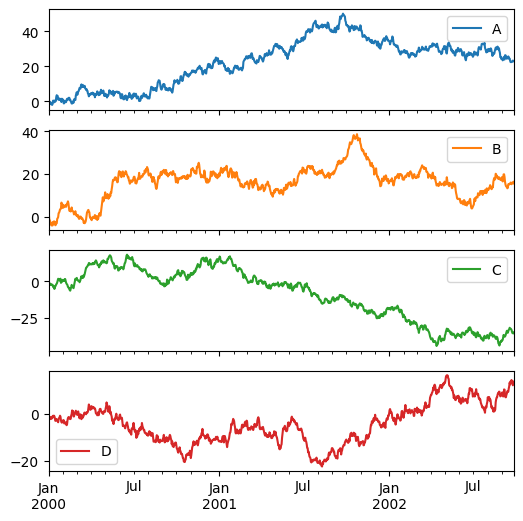

In [107]:
df.plot(subplots=True, figsize=(6, 6))

#### Using layout and targeting multiple axes
- The layout of subplots can be specified by the layout keyword. It can accept (rows, columns). The layout keyword can be used in hist and boxplot also. If the input is invalid, a ValueError will be raised.

- The number of axes which can be contained by rows x columns specified by layout must be larger than the number of required subplots. If layout can contain more axes than required, blank axes are not drawn. Similar to a NumPy array’s reshape method, you can use -1 for one dimension to automatically calculate the number of rows or columns needed, given the other.

array([[<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

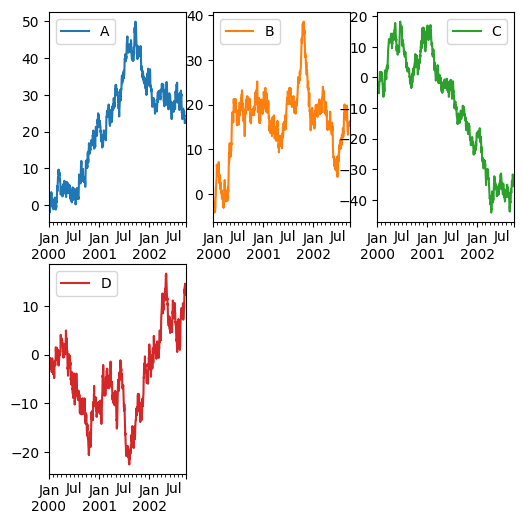

In [108]:
df.plot(subplots=True, layout=(2, 3), figsize=(6, 6), sharex=False)

- The above example is identical to using:

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

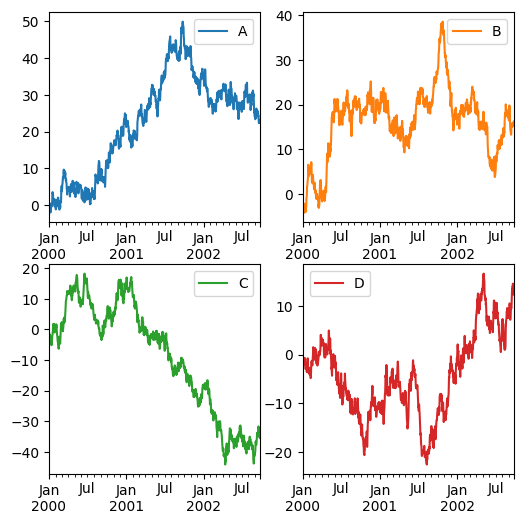

In [109]:
df.plot(subplots=True, layout=(2, -1), figsize=(6, 6), sharex=False)

- The required number of columns (3) is inferred from the number of series to plot and the given number of rows (2).

- You can pass multiple axes created beforehand as list-like via ax keyword. This allows more complicated layouts. The passed axes must be the same number as the subplots being drawn.

- When multiple axes are passed via the ax keyword, layout, sharex and sharey keywords don’t affect to the output. You should explicitly pass sharex=False and sharey=False, otherwise you will see a warning.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

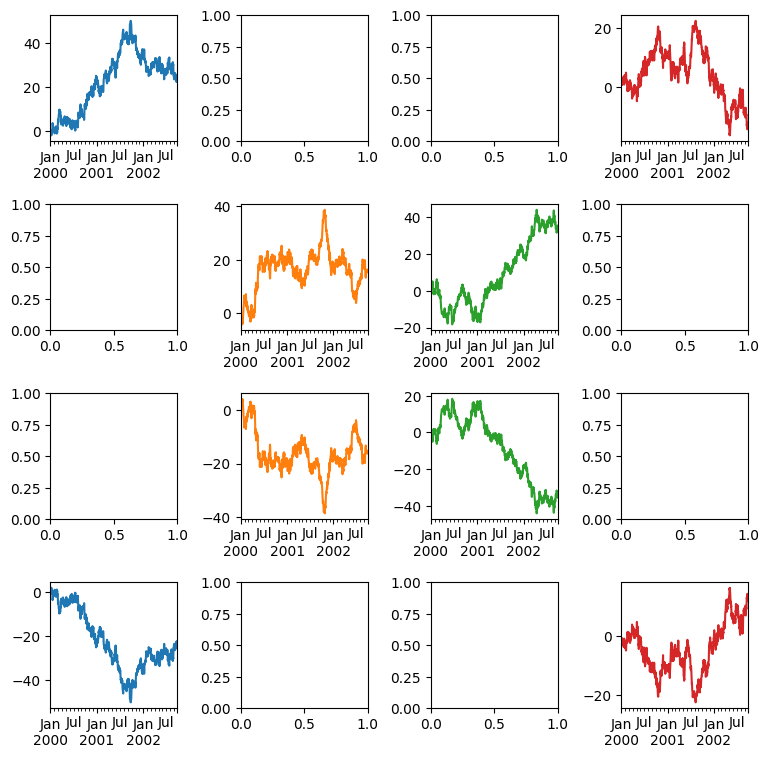

In [110]:
fig, axes = plt.subplots(4, 4, figsize=(9, 9))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
target1 = [axes[0][0], axes[1][1], axes[2][2], axes[3][3]]
target2 = [axes[3][0], axes[2][1], axes[1][2], axes[0][3]]
df.plot(subplots=True, ax=target1, legend=False, sharex=False, sharey=False)
(-df).plot(subplots=True, ax=target2, legend=False, sharex=False, sharey=False)

- Another option is passing an ax argument to Series.plot() to plot on a particular axis:

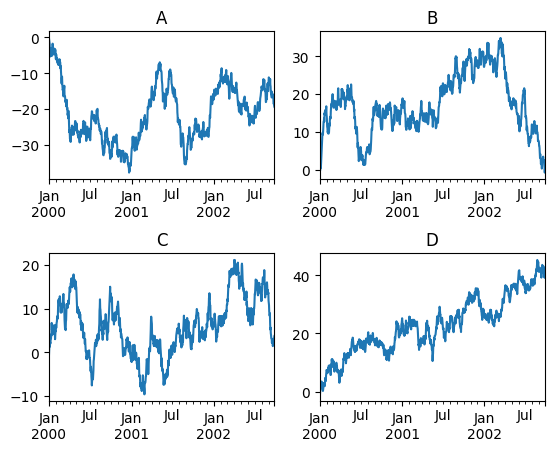

In [111]:
np.random.seed(123456)
ts = pd.Series(np.random.randn(1000), index=pd.date_range("1/1/2000", periods=1000))
ts = ts.cumsum()

df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list("ABCD"))
df = df.cumsum()

fig, axes = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
df["A"].plot(ax=axes[0, 0])

axes[0, 0].set_title("A")
df["B"].plot(ax=axes[0, 1])

axes[0, 1].set_title("B")
df["C"].plot(ax=axes[1, 0])


axes[1, 0].set_title("C")
df["D"].plot(ax=axes[1, 1])
axes[1, 1].set_title("D")

plt.show()


#### Plotting with error bars
- Plotting with error bars is supported in DataFrame.plot() and Series.plot().

- Horizontal and vertical error bars can be supplied to the xerr and yerr keyword arguments to plot(). The error values can be specified using a variety of formats:
    - As a DataFrame or dict of errors with column names matching the columns attribute of the plotting DataFrame or matching the name attribute of the Series.
    - As a str indicating which of the columns of plotting DataFrame contain the error values.
    - As raw values (list, tuple, or np.ndarray). Must be the same length as the plotting DataFrame/Series.

- Here is an example of one way to easily plot group means with standard deviations from the raw data.

In [113]:
# Generate the data
ix3 = pd.MultiIndex.from_arrays(
    [
        ["a", "a", "a", "a", "a", "b", "b", "b", "b", "b"],
        ["foo", "foo", "foo", "bar", "bar", "foo", "foo", "bar", "bar", "bar"],
    ],
    names=["letter", "word"],
)

df3 = pd.DataFrame(
    {
        "data1": [9, 3, 2, 4, 3, 2, 4, 6, 3, 2],
        "data2": [9, 6, 5, 7, 5, 4, 5, 6, 5, 1],
    },
    index=ix3,
)


# Group by index labels and take the means and standard deviations
# for each group
gp3 = df3.groupby(level=("letter", "word"))
means = gp3.mean()
errors = gp3.std()
means


data1     data2
letter word                    
a      bar   3.500000  6.000000
       foo   4.666667  6.666667
b      bar   3.666667  4.000000
       foo   3.000000  4.500000

In [114]:
errors

data1     data2
letter word                    
a      bar   0.707107  1.414214
       foo   3.785939  2.081666
b      bar   2.081666  2.645751
       foo   1.414214  0.707107

<Axes: xlabel='letter,word'>

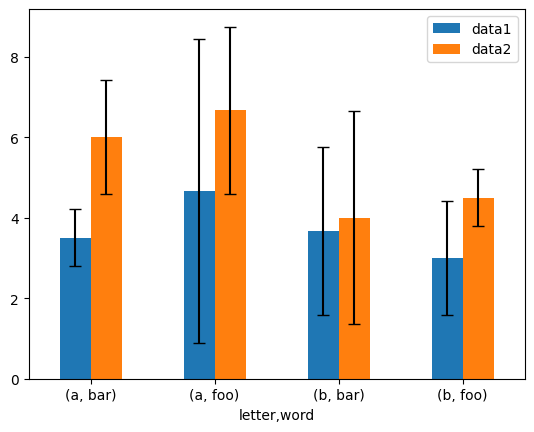

In [115]:
fig, ax = plt.subplots()
means.plot.bar(yerr=errors, ax=ax, capsize=4, rot=0)

- Asymmetrical error bars are also supported, however raw error values must be provided in this case. For a N length Series, a 2xN array should be provided indicating lower and upper (or left and right) errors. For a MxN DataFrame, asymmetrical errors should be in a Mx2xN array.

- Here is an example of one way to plot the min/max range using asymmetrical error bars.

<Axes: xlabel='letter,word'>

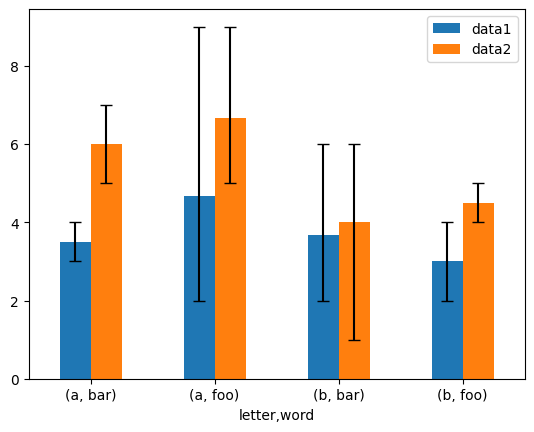

In [116]:
mins = gp3.min()
maxs = gp3.max()

# errors should be positive, and defined in the order of lower, upper
errors = [[means[c] - mins[c], maxs[c] - means[c]] for c in df3.columns]

fig, ax = plt.subplots()
means.plot.bar(yerr=errors, ax=ax, capsize=4, rot=0)

#### Plotting tables
- Plotting with matplotlib table is now supported in DataFrame.plot() and Series.plot() with a table keyword. The table keyword can accept bool, DataFrame or Series. The simple way to draw a table is to specify table=True. Data will be transposed to meet matplotlib’s default layout.

<Axes: >

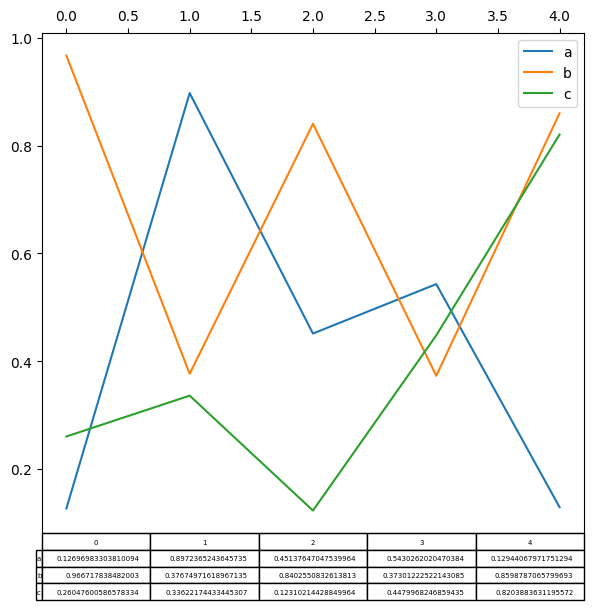

In [117]:
np.random.seed(123456)

fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))
df = pd.DataFrame(np.random.rand(5, 3), columns=["a", "b", "c"])
ax.xaxis.tick_top()  # Display x-axis ticks on top.

df.plot(table=True, ax=ax)

- Also, you can pass a different DataFrame or Series to the table keyword. The data will be drawn as displayed in print method (not transposed automatically). If required, it should be transposed manually as seen in the example below.

<Axes: >

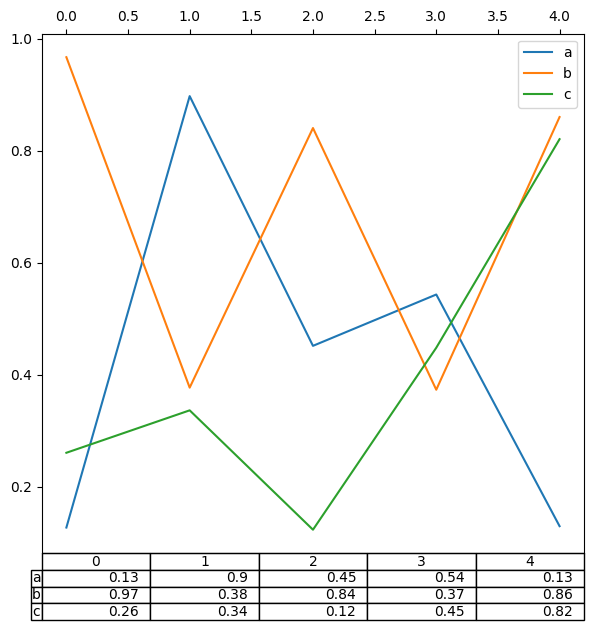

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6.75))

ax.xaxis.tick_top()  # Display x-axis ticks on top.

df.plot(table=np.round(df.T, 2), ax=ax)

- There also exists a helper function pandas.plotting.table, which creates a table from DataFrame or Series, and adds it to an matplotlib.Axes instance. This function can accept keywords which the matplotlib table has.

<Axes: >

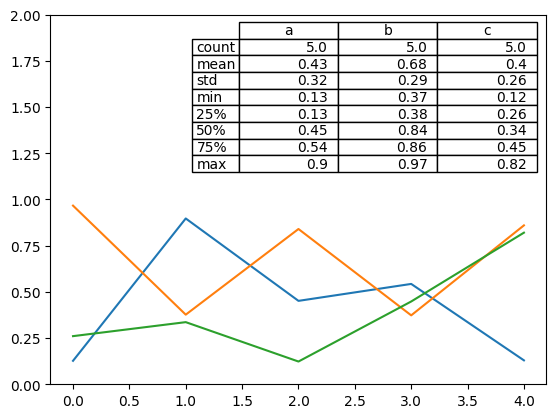

In [119]:
from pandas.plotting import table

fig, ax = plt.subplots(1, 1)
table(ax, np.round(df.describe(), 2), loc="upper right", colWidths=[0.2, 0.2, 0.2]);

df.plot(ax=ax, ylim=(0, 2), legend=None)

#### Colormaps
- A potential issue when plotting a large number of columns is that it can be difficult to distinguish some series due to repetition in the default colors. To remedy this, DataFrame plotting supports the use of the colormap argument, which accepts either a Matplotlib colormap or a string that is a name of a colormap registered with Matplotlib. A visualization of the default matplotlib colormaps is available here.

- As matplotlib does not directly support colormaps for line-based plots, the colors are selected based on an even spacing determined by the number of columns in the DataFrame. There is no consideration made for background color, so some colormaps will produce lines that are not easily visible.

- To use the cubehelix colormap, we can pass colormap='cubehelix'.

<Axes: >

<Figure size 640x480 with 0 Axes>

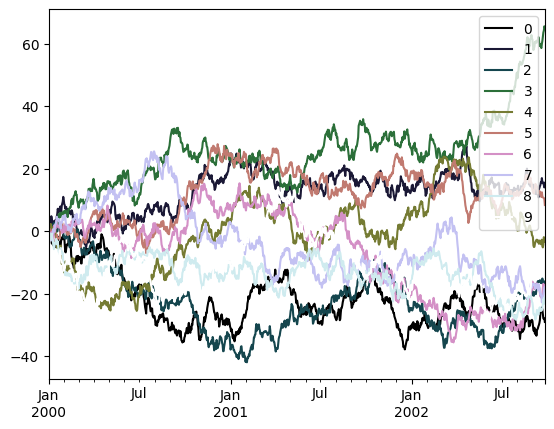

In [120]:
np.random.seed(123456)
df = pd.DataFrame(np.random.randn(1000, 10), index=ts.index)
df = df.cumsum()
plt.figure()
df.plot(colormap="cubehelix")

- Alternatively, we can pass the colormap itself:

<Axes: >

<Figure size 640x480 with 0 Axes>

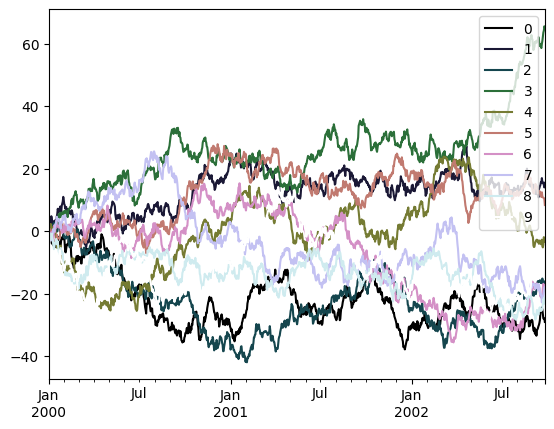

In [121]:
from matplotlib import cm

plt.figure()
df.plot(colormap=cm.cubehelix)

- Colormaps can also be used other plot types, like bar charts:

<Axes: >

<Figure size 640x480 with 0 Axes>

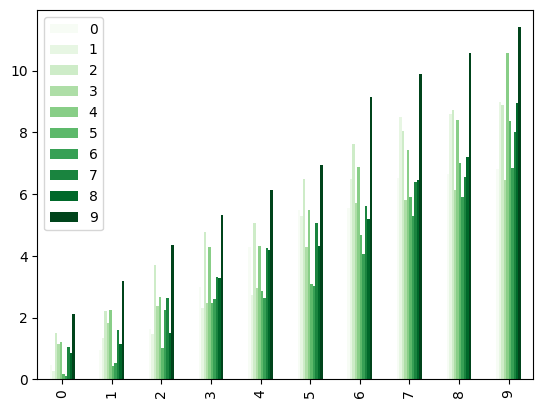

In [122]:
np.random.seed(123456)

dd = pd.DataFrame(np.random.randn(10, 10)).map(abs)
dd = dd.cumsum()
plt.figure()
dd.plot.bar(colormap="Greens")


- Parallel coordinates charts:

<Axes: >

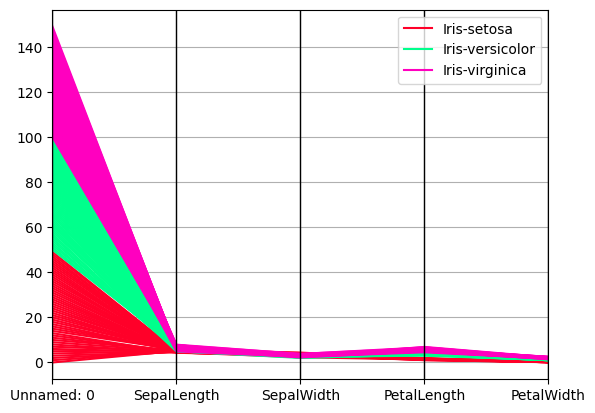

In [123]:
plt.figure()
parallel_coordinates(data, "Name", colormap="gist_rainbow")

- Andrews curves charts:

<Axes: >

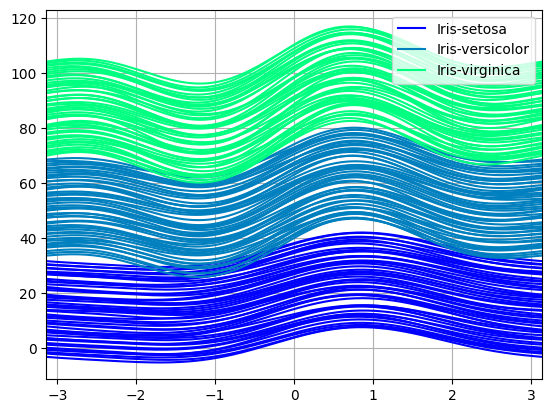

In [124]:
plt.figure()
andrews_curves(data, "Name", colormap="winter")

#### Plotting directly with Matplotlib
- In some situations it may still be preferable or necessary to prepare plots directly with matplotlib, for instance when a certain type of plot or customization is not (yet) supported by pandas. Series and DataFrame objects behave like arrays and can therefore be passed directly to matplotlib functions without explicit casts.

- pandas also automatically registers formatters and locators that recognize date indices, thereby extending date and time support to practically all plot types available in matplotlib. Although this formatting does not provide the same level of refinement you would get when plotting via pandas, it can be faster when plotting a large number of points.

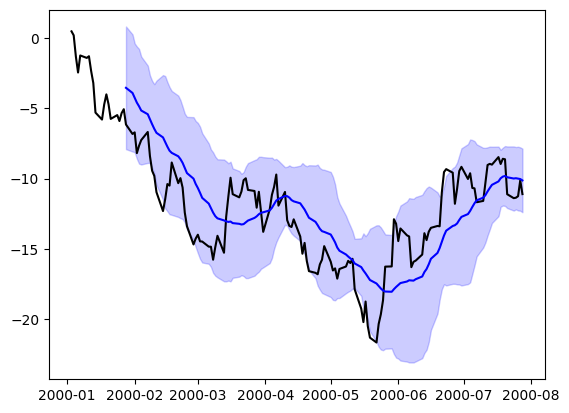

In [125]:
np.random.seed(123456)

price = pd.Series(
    np.random.randn(150).cumsum(),
    index=pd.date_range("2000-1-1", periods=150, freq="B"),
)

ma = price.rolling(20).mean()
mstd = price.rolling(20).std()

plt.figure()
plt.plot(price.index, price, "k")
plt.plot(ma.index, ma, "b")
plt.fill_between(mstd.index, ma - 2 * mstd, ma + 2 * mstd, color="b", alpha=0.2);



#### Plotting backends
- pandas can be extended with third-party plotting backends. The main idea is letting users select a plotting backend different than the provided one based on Matplotlib.

- This can be done by passing ‘backend.module’ as the argument backend in plot function. For example:

`Series([1, 2, 3]).plot(backend="backend.module")`
- Alternatively, you can also set this option globally, do you don’t need to specify the keyword in each plot call. For example:
```
pd.set_option("plotting.backend", "backend.module")
pd.Series([1, 2, 3]).plot()
```

Or:

```
pd.options.plotting.backend = "backend.module"
pd.Series([1, 2, 3]).plot()
```

- This would be more or less equivalent to:

```python
import backend.module
backend.module.plot(pd.Series([1, 2, 3]))
```
- The backend module can then use other visualization tools (Bokeh, Altair, hvplot,…) to generate the plots. Some libraries implementing a backend for pandas are listed on the ecosystem page.


### Table Visualization
- From https://pandas.pydata.org/docs/user_guide/style.html
- This section demonstrates visualization of tabular data using the Styler class. For information on visualization with charting please see Chart Visualization. This document is written as a Jupyter Notebook, and can be viewed or downloaded here.

#### Styler Object and Customising the Display
- Styling and output display customisation should be performed after the data in a DataFrame has been processed. The Styler is not dynamically updated if further changes to the DataFrame are made. The DataFrame.style attribute is a property that returns a Styler object. It has a _repr_html_ method defined on it so it is rendered automatically in Jupyter Notebook.

- The Styler, which can be used for large data but is primarily designed for small data, currently has the ability to output to these formats:
    - HTML
    - LaTeX
    - String (and CSV by extension)
    - Excel
    - (JSON is not currently available)

- The first three of these have display customisation methods designed to format and customise the output. These include:
    - Formatting values, the index and columns headers, using .format() and .format_index(),
    - Renaming the index or column header labels, using .relabel_index()
    - Hiding certain columns, the index and/or column headers, or index names, using .hide()    
    - Concatenating similar DataFrames, using .concat()

#### Formatting the Display
#### Formatting Values
- The Styler distinguishes the display value from the actual value, in both data values and index or columns headers. To control the display value, the text is printed in each cell as a string, and we can use the .format() and .format_index() methods to manipulate this according to a format spec string or a callable that takes a single value and returns a string. It is possible to define this for the whole table, or index, or for individual columns, or MultiIndex levels. We can also overwrite index names.

- Additionally, the format function has a precision argument to specifically help format floats, as well as decimal and thousands separators to support other locales, an na_rep argument to display missing data, and an escape and hyperlinks arguments to help displaying safe-HTML or safe-LaTeX. The default formatter is configured to adopt pandas’ global options such as styler.format.precision option, controllable using with pd.option_context('format.precision', 2):

In [128]:
df = pd.DataFrame({
    "strings": ["Adam", "Mike"],
    "ints": [1, 3],
    "floats": [1.123, 1000.23]
})

df.style \
  .format(precision=3, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1) \
  .relabel_index(["row 1", "row 2"], axis=0)

- Using Styler to manipulate the display is a useful feature because maintaining the indexing and data values for other purposes gives greater control. You do not have to overwrite your DataFrame to display it how you like. Here is a more comprehensive example of using the formatting functions whilst still relying on the underlying data for indexing and calculations.



In [129]:
weather_df = pd.DataFrame(np.random.rand(10,2)*5,
index=pd.date_range(start="2021-01-01", periods=10),
                          columns=["Tokyo", "Beijing"])

def rain_condition(v):
    if v < 1.75:
        return "Dry"
    elif v < 2.75:
        return "Rain"
    return "Heavy Rain"

def make_pretty(styler):
    styler.set_caption("Weather Conditions")
    styler.format(rain_condition)
    styler.format_index(lambda v: v.strftime("%A"))
    styler.background_gradient(axis=None, vmin=1, vmax=5, cmap="YlGnBu")
    return styler

weather_df

Tokyo   Beijing
2021-01-01  2.437040  3.949330
2021-01-02  3.240084  1.285722
2021-01-03  4.893806  1.099624
2021-01-04  3.180508  0.847361
2021-01-05  2.638304  3.057665
2021-01-06  0.439251  3.113046
2021-01-07  3.438518  2.911572
2021-01-08  1.408223  1.254230
2021-01-09  3.050104  2.100607
2021-01-10  3.121639  2.009079

In [130]:
weather_df.loc["2021-01-04":"2021-01-08"].style.pipe(make_pretty)

#### Hiding Data
- The index and column headers can be completely hidden, as well subselecting rows or columns that one wishes to exclude. Both these options are performed using the same methods.

- The index can be hidden from rendering by calling .hide() without any arguments, which might be useful if your index is integer based. Similarly column headers can be hidden by calling .hide(axis=”columns”) without any further arguments.

- Specific rows or columns can be hidden from rendering by calling the same .hide() method and passing in a row/column label, a list-like or a slice of row/column labels to for the subset argument.

- Hiding does not change the integer arrangement of CSS classes, e.g. hiding the first two columns of a DataFrame means the column class indexing will still start at col2, since col0 and col1 are simply ignored.

In [131]:
df = pd.DataFrame(np.random.randn(5, 5))
df.style \
  .hide(subset=[0, 2, 4], axis=0) \
  .hide(subset=[0, 2, 4], axis=1)

- To invert the function to a show functionality it is best practice to compose a list of hidden items.

In [132]:
show = [0, 2, 4]
df.style \
  .hide([row for row in df.index if row not in show], axis=0) \
  .hide([col for col in df.columns if col not in show], axis=1)

#### Concatenating DataFrame Outputs
- Two or more Stylers can be concatenated together provided they share the same columns. This is very useful for showing summary statistics for a DataFrame, and is often used in combination with DataFrame.agg.

- Since the objects concatenated are Stylers they can independently be styled as will be shown below and their concatenation preserves those styles.

In [133]:
summary_styler = df.agg(["sum", "mean"]).style \
                   .format(precision=3) \
                   .relabel_index(["Sum", "Average"])
df.style.format(precision=1).concat(summary_styler)

#### Styler Object and HTML
- The Styler was originally constructed to support the wide array of HTML formatting options. Its HTML output creates an HTML <table> and leverages CSS styling language to manipulate many parameters including colors, fonts, borders, background, etc. See here for more information on styling HTML tables. This allows a lot of flexibility out of the box, and even enables web developers to integrate DataFrames into their exiting user interface designs.

- Below we demonstrate the default output, which looks very similar to the standard DataFrame HTML representation. But the HTML here has already attached some CSS classes to each cell, even if we haven’t yet created any styles. We can view these by calling the .to_html() method, which returns the raw HTML as string, which is useful for further processing or adding to a file - read on in More about CSS and HTML. This section will also provide a walkthrough for how to convert this default output to represent a DataFrame output that is more communicative. For example how we can build s:

In [134]:
df = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, np.nan],[19, 439, 6, 452, 226,232]],
                  index=pd.Index(['Tumour (Positive)', 'Non-Tumour (Negative)'], name='Actual Label:'),
                  columns=pd.MultiIndex.from_product([['Decision Tree', 'Regression', 'Random'],['Tumour', 'Non-Tumour']], names=['Model:', 'Predicted:']))
df.style

- The first step we have taken is the create the Styler object from the DataFrame and then select the range of interest by hiding unwanted columns with .hide().

In [135]:
s = df.style.format('{:.0f}').hide([('Random', 'Tumour'), ('Random', 'Non-Tumour')], axis="columns")
s

#### Methods to Add Styles
- There are 3 primary methods of adding custom CSS styles to Styler:

- Using .set_table_styles() to control broader areas of the table with specified internal CSS. Although table styles allow the flexibility to add CSS selectors and properties controlling all individual parts of the table, they are unwieldy for individual cell specifications. Also, note that table styles cannot be exported to Excel.

- Using .set_td_classes() to directly link either external CSS classes to your data cells or link the internal CSS classes created by .set_table_styles(). See here. These cannot be used on column header rows or indexes, and also won’t export to Excel.

- Using the .apply() and .map() functions to add direct internal CSS to specific data cells. See here. As of v1.4.0 there are also methods that work directly on column header rows or indexes; .apply_index() and .map_index(). Note that only these methods add styles that will export to Excel. These methods work in a similar way to DataFrame.apply() and DataFrame.map().

#### Table Styles
- Table styles are flexible enough to control all individual parts of the table, including column headers and indexes. However, they can be unwieldy to type for individual data cells or for any kind of conditional formatting, so we recommend that table styles are used for broad styling, such as entire rows or columns at a time.

- Table styles are also used to control features which can apply to the whole table at once such as creating a generic hover functionality. The :hover pseudo-selector, as well as other pseudo-selectors, can only be used this way.

- To replicate the normal format of CSS selectors and properties (attribute value pairs), e.g.

`tr:hover {
  background-color: #ffff99;
}`

- the necessary format to pass styles to .set_table_styles() is as a list of dicts, each with a CSS-selector tag and CSS-properties. Properties can either be a list of 2-tuples, or a regular CSS-string, for example:

In [136]:
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}

index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}

headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #000066; color: white;'
}

s.set_table_styles([cell_hover, index_names, headers])


- Next we just add a couple more styling artifacts targeting specific parts of the table. Be careful here, since we are chaining methods we need to explicitly instruct the method not to overwrite the existing styles.

In [137]:
s.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.5em;'},
    {'selector': 'td', 'props': 'text-align: center; font-weight: bold;'},
], overwrite=False)

- As a convenience method (since version 1.2.0) we can also pass a dict to .set_table_styles() which contains row or column keys. Behind the scenes Styler just indexes the keys and adds relevant .col<m> or .row<n> classes as necessary to the given CSS selectors.

In [ ]:
s.set_table_styles({
    ('Regression', 'Tumour'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid #000066'}]
}, overwrite=False, axis=0)

#### Setting Classes and Linking to External CSS
- If you have designed a website then it is likely you will already have an external CSS file that controls the styling of table and cell objects within it. You may want to use these native files rather than duplicate all the CSS in python (and duplicate any maintenance work).

#### Table Attributes
- It is very easy to add a class to the main <table> using .set_table_attributes(). This method can also attach inline styles - read more in CSS Hierarchies.

In [138]:
out = s.set_table_attributes('class="my-table-cls"').to_html()
print(out[out.find('<table'):][:109])

<table id="T_0deeb" class="my-table-cls">
  <thead>
    <tr>
      <th class="index_name level0" >Model:</th>


#### Data Cell CSS Classes

- The .set_td_classes() method accepts a DataFrame with matching indices and columns to the underlying Styler’s DataFrame. That DataFrame will contain strings as css-classes to add to individual data cells: the <td> elements of the <table>. Rather than use external CSS we will create our classes internally and add them to table style. We will save adding the borders until the section on tooltips.

In [139]:
s.set_table_styles([  # create internal CSS classes
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
], overwrite=False)
cell_color = pd.DataFrame([['true ', 'false ', 'true ', 'false '],
                           ['false ', 'true ', 'false ', 'true ']],
                          index=df.index,
                          columns=df.columns[:4])
s.set_td_classes(cell_color)

#### Acting on Data
- We use the following methods to pass your style functions. Both of those methods take a function (and some other keyword arguments) and apply it to the DataFrame in a certain way, rendering CSS styles.
    - .map() (elementwise): accepts a function that takes a single value and returns a string with the CSS attribute-value pair.
    - .apply() (column-/row-/table-wise): accepts a function that takes a Series or DataFrame and returns a Series, DataFrame, or numpy array with an identical shape where each element is a string with a CSS attribute-value pair. This method passes each column or row of your DataFrame one-at-a-time or the entire table at once, depending on the axis keyword argument. For columnwise use axis=0, rowwise use axis=1, and for the entire table at once use axis=None.

- This method is powerful for applying multiple, complex logic to data cells. We create a new DataFrame to demonstrate this.

In [140]:
np.random.seed(0)
df2 = pd.DataFrame(np.random.randn(10,4), columns=['A','B','C','D'])
df2.style

- For example we can build a function that colors text if it is negative, and chain this with a function that partially fades cells of negligible value. Since this looks at each element in turn we use map.

In [141]:
def style_negative(v, props=''):
    return props if v < 0 else None
s2 = df2.style.map(style_negative, props='color:red;')\
              .map(lambda v: 'opacity: 20%;' if (v < 0.3) and (v > -0.3) else None)
s2

- We can also build a function that highlights the maximum value across rows, cols, and the DataFrame all at once. In this case we use apply. Below we highlight the maximum in a column.

In [142]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
s2.apply(highlight_max, props='color:white;background-color:darkblue', axis=0)

- We can use the same function across the different axes, highlighting here the DataFrame maximum in purple, and row maximums in pink.

In [143]:
s2.apply(highlight_max, props='color:white;background-color:pink;', axis=1)\
  .apply(highlight_max, props='color:white;background-color:purple', axis=None)

- This last example shows how some styles have been overwritten by others. In general the most recent style applied is active but you can read more in the section on CSS hierarchies. You can also apply these styles to more granular parts of the DataFrame - read more in section on subset slicing.

- It is possible to replicate some of this functionality using just classes but it can be more cumbersome. See item 3) of Optimization

- Debugging Tip: If you’re having trouble writing your style function, try just passing it into DataFrame.apply. Internally, Styler.apply uses DataFrame.apply so the result should be the same, and with DataFrame.apply you will be able to inspect the CSS string output of your intended function in each cell.

#### Acting on the Index and Column Headers
- Similar application is achieved for headers by using:
    - .map_index() (elementwise): accepts a function that takes a single value and returns a string with the CSS attribute-value pair.
    - .apply_index() (level-wise): accepts a function that takes a Series and returns a Series, or numpy array with an identical shape where each element is a string with a CSS attribute-value pair. This method passes each level of your Index one-at-a-time. To style the index use axis=0 and to style the column headers use axis=1.

- You can select a level of a MultiIndex but currently no similar subset application is available for these methods.

In [144]:
s2.map_index(lambda v: "color:pink;" if v>4 else "color:darkblue;", axis=0)
s2.apply_index(lambda s: np.where(s.isin(["A", "B"]), "color:pink;", "color:darkblue;"), axis=1)

#### Tooltips and Captions
- Table captions can be added with the .set_caption() method. You can use table styles to control the CSS relevant to the caption.

In [145]:
s.set_caption("Confusion matrix for multiple cancer prediction models.")\
 .set_table_styles([{
     'selector': 'caption',
     'props': 'caption-side: bottom; font-size:1.25em;'
 }], overwrite=False)

- Adding tooltips (since version 1.3.0) can be done using the .set_tooltips() method in the same way you can add CSS classes to data cells by providing a string based DataFrame with intersecting indices and columns. You don’t have to specify a css_class name or any css props for the tooltips, since there are standard defaults, but the option is there if you want more visual control.

In [146]:
tt = pd.DataFrame([['This model has a very strong true positive rate',
                    "This model's total number of false negatives is too high"]],
                  index=['Tumour (Positive)'], columns=df.columns[[0,3]])
s.set_tooltips(tt, props='visibility: hidden; position: absolute; z-index: 1; border: 1px solid #000066;'
                         'background-color: white; color: #000066; font-size: 0.8em;'
                         'transform: translate(0px, -24px); padding: 0.6em; border-radius: 0.5em;')

- The only thing left to do for our table is to add the highlighting borders to draw the audience attention to the tooltips. We will create internal CSS classes as before using table styles. Setting classes always overwrites so we need to make sure we add the previous classes.

In [147]:
s.set_table_styles([  # create internal CSS classes
    {'selector': '.border-red', 'props': 'border: 2px dashed red;'},
    {'selector': '.border-green', 'props': 'border: 2px dashed green;'},
], overwrite=False)
cell_border = pd.DataFrame([['border-green ', ' ', ' ', 'border-red '],
                           [' ', ' ', ' ', ' ']],
                          index=df.index,
                          columns=df.columns[:4])
s.set_td_classes(cell_color + cell_border)

#### Finer Control with Slicing
- The examples we have shown so far for the Styler.apply and Styler.map functions have not demonstrated the use of the subset argument. This is a useful argument which permits a lot of flexibility: it allows you to apply styles to specific rows or columns, without having to code that logic into your style function.

- The value passed to subset behaves similar to slicing a DataFrame;
    - A scalar is treated as a column label
    - A list (or Series or NumPy array) is treated as multiple column labels
    - A tuple is treated as (row_indexer, column_indexer)

- Consider using pd.IndexSlice to construct the tuple for the last one. We will create a MultiIndexed DataFrame to demonstrate the functionality.

In [148]:
df3 = pd.DataFrame(np.random.randn(4,4),
                   pd.MultiIndex.from_product([['A', 'B'], ['r1', 'r2']]),
                   columns=['c1','c2','c3','c4'])
df3

c1        c2        c3        c4
A r1 -1.048553 -1.420018 -1.706270  1.950775
  r2 -0.509652 -0.438074 -1.252795  0.777490
B r1 -1.613898 -0.212740 -0.895467  0.386902
  r2 -0.510805 -1.180632 -0.028182  0.428332

- We will use subset to highlight the maximum in the third and fourth columns with red text. We will highlight the subset sliced region in yellow.

In [149]:
slice_ = ['c3', 'c4']
df3.style.apply(highlight_max, props='color:red;', axis=0, subset=slice_)\
         .set_properties(**{'background-color': '#ffffb3'}, subset=slice_)

- If combined with the IndexSlice as suggested then it can index across both dimensions with greater flexibility.

In [150]:
idx = pd.IndexSlice
slice_ = idx[idx[:,'r1'], idx['c2':'c4']]
df3.style.apply(highlight_max, props='color:red;', axis=0, subset=slice_)\
         .set_properties(**{'background-color': '#ffffb3'}, subset=slice_)

- This also provides the flexibility to sub select rows when used with the axis=1.

In [151]:
slice_ = idx[idx[:,'r2'], :]
df3.style.apply(highlight_max, props='color:red;', axis=1, subset=slice_)\
         .set_properties(**{'background-color': '#ffffb3'}, subset=slice_)

- There is also scope to provide conditional filtering.

- Suppose we want to highlight the maximum across columns 2 and 4 only in the case that the sum of columns 1 and 3 is less than -2.0 (essentially excluding rows (:,'r2')).

In [152]:
slice_ = idx[idx[(df3['c1'] + df3['c3']) < -2.0], ['c2', 'c4']]
df3.style.apply(highlight_max, props='color:red;', axis=1, subset=slice_)\
         .set_properties(**{'background-color': '#ffffb3'}, subset=slice_)

- Only label-based slicing is supported right now, not positional, and not callables.

- If your style function uses a subset or axis keyword argument, consider wrapping your function in a functools.partial, partialing out that keyword.

`my_func2 = functools.partial(my_func, subset=42)`

#### Optimization
- Generally, for smaller tables and most cases, the rendered HTML does not need to be optimized, and we don’t really recommend it. There are two cases where it is worth considering:
    - If you are rendering and styling a very large HTML table, certain browsers have performance issues.
    - I- f you are using Styler to dynamically create part of online user interfaces and want to improve network performance.

- Here we recommend the following steps to implement:

1. Remove UUID and cell_ids
- Ignore the uuid and set cell_ids to False. This will prevent unnecessary HTML.

- This is sub-optimal:

In [154]:
df4 = pd.DataFrame([[1,2],[3,4]])
s4 = df4.style

- This is better:

In [155]:
from pandas.io.formats.style import Styler
s4 = Styler(df4, uuid_len=0, cell_ids=False)

2. Use table styles
Use table styles where possible (e.g. for all cells or rows or columns at a time) since the CSS is nearly always more efficient than other formats.
- This is sub-optimal:

In [156]:
props = 'font-family: "Times New Roman", Times, serif; color: #e83e8c; font-size:1.3em;'
df4.style.map(lambda x: props, subset=[1])

- This is better:

In [157]:
df4.style.set_table_styles([{'selector': 'td.col1', 'props': props}])

3. Set classes instead of using Styler functions
- For large DataFrames where the same style is applied to many cells it can be more efficient to declare the styles as classes and then apply those classes to data cells, rather than directly applying styles to cells. It is, however, probably still easier to use the Styler function api when you are not concerned about optimization.

- This is sub-optimal:

In [158]:
df2.style.apply(highlight_max, props='color:white;background-color:darkblue;', axis=0)\
         .apply(highlight_max, props='color:white;background-color:pink;', axis=1)\
         .apply(highlight_max, props='color:white;background-color:purple', axis=None)

- This is better:

In [159]:
build = lambda x: pd.DataFrame(x, index=df2.index, columns=df2.columns)
cls1 = build(df2.apply(highlight_max, props='cls-1 ', axis=0))
cls2 = build(df2.apply(highlight_max, props='cls-2 ', axis=1, result_type='expand').values)
cls3 = build(highlight_max(df2, props='cls-3 '))
df2.style.set_table_styles([
    {'selector': '.cls-1', 'props': 'color:white;background-color:darkblue;'},
    {'selector': '.cls-2', 'props': 'color:white;background-color:pink;'},
    {'selector': '.cls-3', 'props': 'color:white;background-color:purple;'}
]).set_td_classes(cls1 + cls2 + cls3)

4. Don’t use tooltips
- Tooltips require cell_ids to work and they generate extra HTML elements for every data cell.

5. If every byte counts use string replacement
- You can remove unnecessary HTML, or shorten the default class names by replacing the default css dict. You can read a little more about CSS below.

In [160]:
my_css = {
    "row_heading": "",
    "col_heading": "",
    "index_name": "",
    "col": "c",
    "row": "r",
    "col_trim": "",
    "row_trim": "",
    "level": "l",
    "data": "",
    "blank": "",
}
html = Styler(df4, uuid_len=0, cell_ids=False)
html.set_table_styles([{'selector': 'td', 'props': props},
                       {'selector': '.c1', 'props': 'color:green;'},
                       {'selector': '.l0', 'props': 'color:blue;'}],
                      css_class_names=my_css)
print(html.to_html())

<style type="text/css">
#T_ td {
  font-family: "Times New Roman", Times, serif;
  color: #e83e8c;
  font-size: 1.3em;
}
#T_ .c1 {
  color: green;
}
#T_ .l0 {
  color: blue;
}
</style>
<table id="T_">
  <thead>
    <tr>
      <th class=" l0" >&nbsp;</th>
      <th class=" l0 c0" >0</th>
      <th class=" l0 c1" >1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th class=" l0 r0" >0</th>
      <td class=" r0 c0" >1</td>
      <td class=" r0 c1" >2</td>
    </tr>
    <tr>
      <th class=" l0 r1" >1</th>
      <td class=" r1 c0" >3</td>
      <td class=" r1 c1" >4</td>
    </tr>
  </tbody>
</table>



#### Builtin Styles
- Some styling functions are common enough that we’ve “built them in” to the Styler, so you don’t have to write them and apply them yourself. The current list of such functions is:
    - .highlight_null: for use with identifying missing data.
    - .highlight_min and .highlight_max: for use with identifying extremeties in data.
    - .highlight_between and .highlight_quantile: for use with identifying classes within data.
    - .background_gradient: a flexible method for highlighting cells based on their, or other, values on a numeric scale.
    - .text_gradient: similar method for highlighting text based on their, or other, values on a numeric scale.
    - .bar: to display mini-charts within cell backgrounds.

- The individual documentation on each function often gives more examples of their arguments.

#### Highlight Null

In [161]:
df2.iloc[0,2] = np.nan
df2.iloc[4,3] = np.nan
df2.loc[:4].style.highlight_null(color='yellow')

#### Highlight Min or Max

In [162]:
df2.loc[:4].style.highlight_max(axis=1, props='color:white; font-weight:bold; background-color:darkblue;')

#### Highlight Between
- This method accepts ranges as float, or NumPy arrays or Series provided the indexes match.

In [163]:
left = pd.Series([1.0, 0.0, 1.0], index=["A", "B", "D"])
df2.loc[:4].style.highlight_between(left=left, right=1.5, axis=1, props='color:white; background-color:purple;')

#### Highlight Quantile
- Useful for detecting the highest or lowest percentile values

In [164]:
df2.loc[:4].style.highlight_quantile(q_left=0.85, axis=None, color='yellow')

#### Background Gradient and Text Gradient
- You can create “heatmaps” with the background_gradient and text_gradient methods. These require matplotlib, and we’ll use Seaborn to get a nice colormap.

In [165]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

df2.style.background_gradient(cmap=cm)

In [166]:
df2.style.text_gradient(cmap=cm)

- .background_gradient and .text_gradient have a number of keyword arguments to customise the gradients and colors. See the documentation.

#### Set properties
- Use Styler.set_properties when the style doesn’t actually depend on the values. This is just a simple wrapper for .map where the function returns the same properties for all cells.

In [167]:
df2.loc[:4].style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

#### Bar charts
- You can include “bar charts” in your DataFrame.

In [168]:
df2.style.bar(subset=['A', 'B'], color='#d65f5f')

- Additional keyword arguments give more control on centering and positioning, and you can pass a list of [color_negative, color_positive] to highlight lower and higher values or a matplotlib colormap.

- To showcase an example here’s how you can change the above with the new align option, combined with setting vmin and vmax limits, the width of the figure, and underlying css props of cells, leaving space to display the text and the bars. We also use text_gradient to color the text the same as the bars using a matplotlib colormap (although in this case the visualization is probably better without this additional effect).

In [169]:
df2.style.format('{:.3f}', na_rep="")\
         .bar(align=0, vmin=-2.5, vmax=2.5, cmap="bwr", height=50,
              width=60, props="width: 120px; border-right: 1px solid black;")\
         .text_gradient(cmap="bwr", vmin=-2.5, vmax=2.5)

- The following example aims to give a highlight of the behavior of the new align options:

#### Sharing styles
- Say you have a lovely style built up for a DataFrame, and now you want to apply the same style to a second DataFrame. Export the style with df1.style.export, and import it on the second DataFrame with df1.style.set

In [171]:
style1 = df2.style\
            .map(style_negative, props='color:red;')\
            .map(lambda v: 'opacity: 20%;' if (v < 0.3) and (v > -0.3) else None)\
            .set_table_styles([{"selector": "th", "props": "color: blue;"}])\
            .hide(axis="index")
style1

In [172]:
style2 = df3.style
style2.use(style1.export())
style2

- Notice that you’re able to share the styles even though they’re data aware. The styles are re-evaluated on the new DataFrame they’ve been used upon.

#### Limitations
- DataFrame only (use Series.to_frame().style)
- The index and columns do not need to be unique, but certain styling functions can only work with unique indexes.
- No large repr, and construction performance isn’t great; although we have some HTML optimizations
- You can only apply styles, you can’t insert new HTML entities, except via subclassing.

#### Other Fun and Useful Stuff
- Here are a few interesting examples.

#### Widgets
- Styler interacts pretty well with widgets. If you’re viewing this online instead of running the notebook yourself, you’re missing out on interactively adjusting the color palette.


In [173]:
from ipywidgets import widgets
@widgets.interact
def f(h_neg=(0, 359, 1), h_pos=(0, 359), s=(0., 99.9), l=(0., 99.9)):
    return df2.style.background_gradient(
        cmap=sns.palettes.diverging_palette(h_neg=h_neg, h_pos=h_pos, s=s, l=l,
                                            as_cmap=True)
    )

interactive(children=(IntSlider(value=179, description='h_neg', max=359), IntSlider(value=179, description='h_…

#### Magnify

In [174]:
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "4pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

np.random.seed(25)
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
bigdf = pd.DataFrame(np.random.randn(20, 25)).cumsum()

bigdf.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '1pt'})\
    .set_caption("Hover to magnify")\
    .format(precision=2)\
    .set_table_styles(magnify())

#### Sticky Headers
- If you display a large matrix or DataFrame in a notebook, but you want to always see the column and row headers you can use the .set_sticky method which manipulates the table styles CSS.

In [175]:
bigdf = pd.DataFrame(np.random.randn(16, 100))
bigdf.style.set_sticky(axis="index")

- It is also possible to stick MultiIndexes and even only specific levels.

In [176]:
bigdf.index = pd.MultiIndex.from_product([["A","B"],[0,1],[0,1,2,3]])
bigdf.style.set_sticky(axis="index", pixel_size=18, levels=[1,2])

#### HTML Escaping
- Suppose you have to display HTML within HTML, that can be a bit of pain when the renderer can’t distinguish. You can use the escape formatting option to handle this, and even use it within a formatter that contains HTML itself.

In [177]:
df4 = pd.DataFrame([['<div></div>', '"&other"', '<span></span>']])
df4.style

In [178]:
df4.style.format(escape="html")

In [179]:
df4.style.format('<a href="https://pandas.pydata.org" target="_blank">{}</a>', escape="html")


#### Export to Excel
- Some support (since version 0.20.0) is available for exporting styled DataFrames to Excel worksheets using the OpenPyXL or XlsxWriter engines. CSS2.2 properties handled include:
    - background-color

    - border-style properties

    - border-width properties

    - border-color properties

    - color

    - font-family

    - font-style

    - font-weight

    - text-align

    - text-decoration

    - vertical-align

    - white-space: nowrap

    - Shorthand and side-specific border properties are supported (e.g. border-style and border-left-style) as well as the border shorthands for all sides (border: 1px solid green) or specified sides (border-left: 1px solid green). Using a border shorthand will override any border properties set before it (See CSS Working Group for more details)

    - Only CSS2 named colors and hex colors of the form #rgb or #rrggbb are currently supported.

    - The following pseudo CSS properties are also available to set Excel specific style properties:

        - number-format

        - border-style (for Excel-specific styles: “hair”, “mediumDashDot”, “dashDotDot”, “mediumDashDotDot”, “dashDot”, “slantDashDot”, or “mediumDashed”)

- Table level styles, and data cell CSS-classes are not included in the export to Excel: individual cells must have their properties mapped by the Styler.apply and/or Styler.map methods.

```python
df2.style.\
    map(style_negative, props='color:red;').\
    highlight_max(axis=0).\
    to_excel('styled.xlsx', engine='openpyxl')
```

#### Export to LaTeX
- There is support (since version 1.3.0) to export Styler to LaTeX. The documentation for the .to_latex method gives further detail and numerous examples.

#### More About CSS and HTML
- Cascading Style Sheet (CSS) language, which is designed to influence how a browser renders HTML elements, has its own peculiarities. It never reports errors: it just silently ignores them and doesn’t render your objects how you intend so can sometimes be frustrating. Here is a very brief primer on how Styler creates HTML and interacts with CSS, with advice on common pitfalls to avoid.

#### CSS Classes and Ids
- The precise structure of the CSS class attached to each cell is as follows.
- Cells with Index and Column names include index_name and level<k> where k is its level in a MultiIndex
- Index label cells include
    - row_heading
    - level<k> where k is the level in a MultiIndex
    - row<m> where m is the numeric position of the row

- Column label cells include
    - col_heading
    - level<k> where k is the level in a MultiIndex
    - col<n> where n is the numeric position of the column

- Data cells include
    - data
    - row<m>, where m is the numeric position of the cell.
    - col<n>, where n is the numeric position of the cell.
- Blank cells include blank
- Trimmed cells include col_trim or row_trim

- The structure of the id is T_uuid_level<k>_row<m>_col<n> where level<k> is used only on headings, and headings will only have either row<m> or col<n> whichever is needed. By default we’ve also prepended each row/column identifier with a UUID unique to each DataFrame so that the style from one doesn’t collide with the styling from another within the same notebook or page. You can read more about the use of UUIDs in Optimization.

- We can see example of the HTML by calling the .to_html() method.

In [180]:
print(pd.DataFrame([[1,2],[3,4]], index=['i1', 'i2'], columns=['c1', 'c2']).style.to_html())

<style type="text/css">
</style>
<table id="T_09b1c">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_09b1c_level0_col0" class="col_heading level0 col0" >c1</th>
      <th id="T_09b1c_level0_col1" class="col_heading level0 col1" >c2</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_09b1c_level0_row0" class="row_heading level0 row0" >i1</th>
      <td id="T_09b1c_row0_col0" class="data row0 col0" >1</td>
      <td id="T_09b1c_row0_col1" class="data row0 col1" >2</td>
    </tr>
    <tr>
      <th id="T_09b1c_level0_row1" class="row_heading level0 row1" >i2</th>
      <td id="T_09b1c_row1_col0" class="data row1 col0" >3</td>
      <td id="T_09b1c_row1_col1" class="data row1 col1" >4</td>
    </tr>
  </tbody>
</table>



#### CSS Hierarchies
- The examples have shown that when CSS styles overlap, the one that comes last in the HTML render, takes precedence. So the following yield different results:

In [181]:
df4 = pd.DataFrame([['text']])
df4.style.map(lambda x: 'color:green;')\
         .map(lambda x: 'color:red;')

In [182]:
df4.style.map(lambda x: 'color:red;')\
         .map(lambda x: 'color:green;')

- This is only true for CSS rules that are equivalent in hierarchy, or importance. You can read more about CSS specificity here but for our purposes it suffices to summarize the key points:

- A CSS importance score for each HTML element is derived by starting at zero and adding:
    - 1000 for an inline style attribute
    - 100 for each ID
    - 10 for each attribute, class or pseudo-class
    - 1 for each element name or pseudo-element

- Let’s use this to describe the action of the following configurations

In [183]:
df4.style.set_uuid('a_')\
         .set_table_styles([{'selector': 'td', 'props': 'color:red;'}])\
         .map(lambda x: 'color:green;')

- This text is red because the generated selector #T_a_ td is worth 101 (ID plus element), whereas #T_a_row0_col0 is only worth 100 (ID), so is considered inferior even though in the HTML it comes after the previous.

In [184]:
df4.style.set_uuid('b_')\
         .set_table_styles([{'selector': 'td', 'props': 'color:red;'},
                            {'selector': '.cls-1', 'props': 'color:blue;'}])\
         .map(lambda x: 'color:green;')\
         .set_td_classes(pd.DataFrame([['cls-1']]))

- In the above case the text is blue because the selector #T_b_ .cls-1 is worth 110 (ID plus class), which takes precedence.

In [185]:
df4.style.set_uuid('c_')\
         .set_table_styles([{'selector': 'td', 'props': 'color:red;'},
                            {'selector': '.cls-1', 'props': 'color:blue;'},
                            {'selector': 'td.data', 'props': 'color:yellow;'}])\
         .map(lambda x: 'color:green;')\
         .set_td_classes(pd.DataFrame([['cls-1']]))

- Now we have created another table style this time the selector T_c_ td.data (ID plus element plus class) gets bumped up to 111.
- If your style fails to be applied, and its really frustrating, try the !important trump card.

In [186]:
df4.style.set_uuid('d_')\
         .set_table_styles([{'selector': 'td', 'props': 'color:red;'},
                            {'selector': '.cls-1', 'props': 'color:blue;'},
                            {'selector': 'td.data', 'props': 'color:yellow;'}])\
         .map(lambda x: 'color:green !important;')\
         .set_td_classes(pd.DataFrame([['cls-1']]))

- Finally got that green text after all!
#### Extensibility
- The core of pandas is, and will remain, its “high-performance, easy-to-use data structures”. With that in mind, we hope that DataFrame.style accomplishes two goals
    - Provide an API that is pleasing to use interactively and is “good enough” for many tasks
    - Provide the foundations for dedicated libraries to build on

- If you build a great library on top of this, let us know and we’ll link to it.

#### Subclassing
- If the default template doesn’t quite suit your needs, you can subclass Styler and extend or override the template. We’ll show an example of extending the default template to insert a custom header before each table.

In [187]:
from jinja2 import Environment, ChoiceLoader, FileSystemLoader
from IPython.display import HTML
from pandas.io.formats.style import Styler

- We’ll use the following template:

In [188]:
# with open("templates/myhtml.tpl") as f:
#     print(f.read())

- Now that we’ve created a template, we need to set up a subclass of Styler that knows about it.



In [189]:
# class MyStyler(Styler):
#     env = Environment(
#         loader=ChoiceLoader([
#             FileSystemLoader("templates"),  # contains ours
#             Styler.loader,  # the default
#         ])
#     )
#     # template_html_table = env.get_template("myhtml.tpl")

- Notice that we include the original loader in our environment’s loader. That’s because we extend the original template, so the Jinja environment needs to be able to find it.

- Now we can use that custom styler. It’s __init__ takes a DataFrame.

In [191]:
# MyStyler(df3)

- Our custom template accepts a table_title keyword. We can provide the value in the .to_html method.

In [192]:
# HTML(MyStyler(df3).to_html(table_title="Extending Example"))

- For convenience, we provide the Styler.from_custom_template method that does the same as the custom subclass.

In [193]:
# EasyStyler = Styler.from_custom_template("templates", "myhtml.tpl")
# HTML(EasyStyler(df3).to_html(table_title="Another Title"))

#### Template Structure
- Here’s the template structure for the both the style generation template and the table generation template:

- Style template:

In [194]:
# HTML(style_structure)

- Table template:

In [195]:
# HTML(table_structure)

#### Group by: split-apply-combine
- From https://pandas.pydata.org/docs/user_guide/groupby.html
- By “group by” we are referring to a process involving one or more of the following steps:
    - Splitting the data into groups based on some criteria.
    - Applying a function to each group independently.
    - Combining the results into a data structure.

- Out of these, the split step is the most straightforward. In the apply step, we might wish to do one of the following:
    - Aggregation: compute a summary statistic (or statistics) for each group. Some examples:
        - Compute group sums or means.
        - Compute group sizes / counts.
    - Transformation: perform some group-specific computations and return a like-indexed object. Some examples:
        - Standardize data (zscore) within a group.
        - Filling NAs within groups with a value derived from each group.
    - Filtration: discard some groups, according to a group-wise computation that evaluates to True or False. Some examples:
        - Discard data that belong to groups with only a few members.
        - Filter out data based on the group sum or mean.
- Many of these operations are defined on GroupBy objects. These operations are similar to those of the aggregating API, window API, and resample API.

- It is possible that a given operation does not fall into one of these categories or is some combination of them. In such a case, it may be possible to compute the operation using GroupBy’s apply method. This method will examine the results of the apply step and try to sensibly combine them into a single result if it doesn’t fit into either of the above three categories.

- **Note**: An operation that is split into multiple steps using built-in GroupBy operations will be more efficient than using the apply method with a user-defined Python function.

- The name GroupBy should be quite familiar to those who have used a SQL-based tool (or itertools), in which you can write code like:
```SQL
SELECT Column1, Column2, mean(Column3), sum(Colum4)
FROM SomeTable
GROUP BY Column1, Column2
```
- We aim to make operations like this natural and easy to express using pandas. We’ll address each area of GroupBy functionality, then provide some non-trivial examples / use cases.

#### Splitting an object into groups
- The abstract definition of grouping is to provide a mapping of labels to group names. To create a GroupBy object (more on what the GroupBy object is later), you may do the following:

In [196]:
speeds = pd.DataFrame(
    [
        ("bird", "Falconiformes", 389.0),
        ("bird", "Psittaciformes", 24.0),
        ("mammal", "Carnivora", 80.2),
        ("mammal", "Primates", np.nan),
        ("mammal", "Carnivora", 58),
    ],
    index=["falcon", "parrot", "lion", "monkey", "leopard"],
    columns=("class", "order", "max_speed"),
)
speeds

class           order  max_speed
falcon     bird   Falconiformes      389.0
parrot     bird  Psittaciformes       24.0
lion     mammal       Carnivora       80.2
monkey   mammal        Primates        NaN
leopard  mammal       Carnivora       58.0

In [197]:
grouped = speeds.groupby("class")
grouped = speeds.groupby(["class", "order"])

- The mapping can be specified many different ways:
    - A Python function, to be called on each of the index labels.
    - A list or NumPy array of the same length as the index.
    - A dict or Series, providing a label -> group name mapping.
    - For DataFrame objects, a string indicating either a column name or an index level name to be used to group.
    - A list of any of the above things.

- Collectively we refer to the grouping objects as the keys. For example, consider the following DataFrame:

- **Note**: A string passed to groupby may refer to either a column or an index level. If a string matches both a column name and an index level name, a ValueError will be raised.

In [198]:
df = pd.DataFrame(
    {
        "A": ["foo", "bar", "foo", "bar", "foo", "bar", "foo", "foo"],
        "B": ["one", "one", "two", "three", "two", "two", "one", "three"],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

df

A      B         C         D
0  foo    one -0.084771  0.666648
1  bar    one  0.140705 -0.984262
2  foo    two  1.045174  0.920993
3  bar  three  0.183076  0.445224
4  foo    two -0.624110 -0.504117
5  bar    two  0.161927  0.746309
6  foo    one  0.697439  0.558314
7  foo  three  1.978547  2.026190

- On a DataFrame, we obtain a GroupBy object by calling groupby(). This method returns a pandas.api.typing.DataFrameGroupBy instance. We could naturally group by either the A or B columns, or both:

In [199]:
grouped = df.groupby("A")
grouped = df.groupby("B")
grouped = df.groupby(["A", "B"])

- **Note**: df.groupby('A') is just syntactic sugar for df.groupby(df['A']).
- If we also have a MultiIndex on columns A and B, we can group by all the columns except the one we specify:

In [200]:
df2 = df.set_index(["A", "B"])
grouped = df2.groupby(level=df2.index.names.difference(["B"]))
grouped.sum()

C         D
A                      
bar  0.485708  0.207271
foo  3.012281  3.668027

- The above GroupBy will split the DataFrame on its index (rows). To split by columns, first do a transpose:

In [201]:
def get_letter_type(letter):
    if letter.lower() in 'aeiou':
        return 'vowel'
    else:
        return 'consonant'

grouped = df.T.groupby(get_letter_type)

- pandas Index objects support duplicate values. If a non-unique index is used as the group key in a groupby operation, all values for the same index value will be considered to be in one group and thus the output of aggregation functions will only contain unique index values:

In [202]:
index = [1, 2, 3, 1, 2, 3]
s = pd.Series([1, 2, 3, 10, 20, 30], index=index)
s

1     1
2     2
3     3
1    10
2    20
3    30
dtype: int64

In [203]:
grouped = s.groupby(level=0)
grouped.first()

1    1
2    2
3    3
dtype: int64

In [204]:
grouped.last()

1    10
2    20
3    30
dtype: int64

In [205]:
grouped.sum()

1    11
2    22
3    33
dtype: int64

- **Note**: that no splitting occurs until it’s needed. Creating the GroupBy object only verifies that you’ve passed a valid mapping.
- **Note**: Many kinds of complicated data manipulations can be expressed in terms of GroupBy operations (though it can’t be guaranteed to be the most efficient implementation). You can get quite creative with the label mapping functions.

#### GroupBy sorting
- By default the group keys are sorted during the groupby operation. You may however pass sort=False for potential speedups. With sort=False the order among group-keys follows the order of appearance of the keys in the original dataframe:

In [206]:
df2 = pd.DataFrame({"X": ["B", "B", "A", "A"], "Y": [1, 2, 3, 4]})
df2.groupby(["X"]).sum()


Y
X   
A  7
B  3

In [207]:
df2.groupby(["X"], sort=False).sum()

Y
X   
B  3
A  7

- Note that groupby will preserve the order in which observations are sorted within each group. For example, the groups created by groupby() below are in the order they appeared in the original DataFrame:

In [208]:
df3 = pd.DataFrame({"X": ["A", "B", "A", "B"], "Y": [1, 4, 3, 2]})
df3.groupby("X").get_group("A")


X  Y
0  A  1
2  A  3

In [209]:
df3.groupby(["X"]).get_group(("B",))

X  Y
1  B  4
3  B  2

#### GroupBy dropna
- By default NA values are excluded from group keys during the groupby operation. However, in case you want to include NA values in group keys, you could pass dropna=False to achieve it.

In [210]:
df_list = [[1, 2, 3], [1, None, 4], [2, 1, 3], [1, 2, 2]]
df_dropna = pd.DataFrame(df_list, columns=["a", "b", "c"])
df_dropna

a    b  c
0  1  2.0  3
1  1  NaN  4
2  2  1.0  3
3  1  2.0  2

In [211]:
# Default ``dropna`` is set to True, which will exclude NaNs in keys
df_dropna.groupby(by=["b"], dropna=True).sum()

a  c
b        
1.0  2  3
2.0  2  5

In [212]:
# In order to allow NaN in keys, set ``dropna`` to False
df_dropna.groupby(by=["b"], dropna=False).sum()

a  c
b        
1.0  2  3
2.0  2  5
NaN  1  4

- The default setting of dropna argument is True which means NA are not included in group keys.
#### GroupBy object attributes
- The groups attribute is a dictionary whose keys are the computed unique groups and corresponding values are the axis labels belonging to each group. In the above example we have:

In [213]:
df.groupby("A").groups

{'bar': [1, 3, 5], 'foo': [0, 2, 4, 6, 7]}

In [214]:
df.T.groupby(get_letter_type).groups

{'consonant': ['B', 'C', 'D'], 'vowel': ['A']}

- Calling the standard Python len function on the GroupBy object returns the number of groups, which is the same as the length of the groups dictionary:

In [215]:
grouped = df.groupby(["A", "B"])
grouped.groups

{('bar', 'one'): [1], ('bar', 'three'): [3], ('bar', 'two'): [5], ('foo', 'one'): [0, 6], ('foo', 'three'): [7], ('foo', 'two'): [2, 4]}

In [216]:
len(grouped)

6

- GroupBy will tab complete column names, GroupBy operations, and other attributes:

In [217]:
n = 10
weight = np.random.normal(166, 20, size=n)
height = np.random.normal(60, 10, size=n)
time = pd.date_range("1/1/2000", periods=n)
gender = np.random.choice(["male", "female"], size=n)
df = pd.DataFrame(
    {"height": height, "weight": weight, "gender": gender}, index=time
)
df

height      weight  gender
2000-01-01  59.175858  165.407280    male
2000-01-02  47.481433  149.115791  female
2000-01-03  58.513800  153.503731  female
2000-01-04  52.839963  164.894125  female
2000-01-05  63.194093  159.634690    male
2000-01-06  45.508417  189.009768    male
2000-01-07  90.877310  192.254073    male
2000-01-08  57.859606  179.688174    male
2000-01-09  79.353119  147.589193  female
2000-01-10  62.325962  183.057504  female

In [218]:
gb = df.groupby("gender")

In [220]:
[name for name in dir(gb) if not name.startswith('__') and not name.startswith("_")] 

['agg',
 'aggregate',
 'all',
 'any',
 'apply',
 'bfill',
 'boxplot',
 'corr',
 'corrwith',
 'count',
 'cov',
 'cumcount',
 'cummax',
 'cummin',
 'cumprod',
 'cumsum',
 'describe',
 'diff',
 'dtypes',
 'ewm',
 'expanding',
 'ffill',
 'fillna',
 'filter',
 'first',
 'gender',
 'get_group',
 'groups',
 'head',
 'height',
 'hist',
 'idxmax',
 'idxmin',
 'indices',
 'last',
 'max',
 'mean',
 'median',
 'min',
 'ndim',
 'ngroup',
 'ngroups',
 'nth',
 'nunique',
 'ohlc',
 'pct_change',
 'pipe',
 'plot',
 'prod',
 'quantile',
 'rank',
 'resample',
 'rolling',
 'sample',
 'sem',
 'shift',
 'size',
 'skew',
 'std',
 'sum',
 'tail',
 'take',
 'transform',
 'value_counts',
 'var',
 'weight']

#### GroupBy with MultiIndex
- With hierarchically-indexed data, it’s quite natural to group by one of the levels of the hierarchy.

- Let’s create a Series with a two-level MultiIndex.

In [221]:
arrays = [
    ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
    ["one", "two", "one", "two", "one", "two", "one", "two"],
]

index = pd.MultiIndex.from_arrays(arrays, names=["first", "second"])
s = pd.Series(np.random.randn(8), index=index)
s

first  second
bar    one      -1.060145
       two      -0.404074
baz    one       1.659674
       two      -0.014732
foo    one      -0.011221
       two       0.223170
qux    one      -0.286891
       two      -1.626631
dtype: float64

- We can then group by one of the levels in s.

In [222]:
grouped = s.groupby(level=0)
grouped.sum()

first
bar   -1.464219
baz    1.644942
foo    0.211949
qux   -1.913522
dtype: float64

- If the MultiIndex has names specified, these can be passed instead of the level number:

In [223]:
s.groupby(level="second").sum()

second
one    0.301416
two   -1.822266
dtype: float64

- Grouping with multiple levels is supported.

In [224]:
arrays = [
    ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
    ["doo", "doo", "bee", "bee", "bop", "bop", "bop", "bop"],
    ["one", "two", "one", "two", "one", "two", "one", "two"],
]
index = pd.MultiIndex.from_arrays(arrays, names=["first", "second", "third"])

s = pd.Series(np.random.randn(8), index=index)

s


first  second  third
bar    doo     one     -0.722578
               two      0.067536
baz    bee     one      0.997481
               two     -0.354422
foo    bop     one      0.572136
               two     -0.740630
qux    bop     one     -1.107224
               two      0.605171
dtype: float64

In [225]:
s.groupby(level=["first", "second"]).sum()

first  second
bar    doo      -0.655042
baz    bee       0.643059
foo    bop      -0.168495
qux    bop      -0.502053
dtype: float64

- Index level names may be supplied as keys.

In [226]:
s.groupby(["first", "second"]).sum()

first  second
bar    doo      -0.655042
baz    bee       0.643059
foo    bop      -0.168495
qux    bop      -0.502053
dtype: float64

- More on the sum function and aggregation later.

#### Grouping DataFrame with Index levels and columns
- A DataFrame may be grouped by a combination of columns and index levels. You can specify both column and index names, or use a Grouper.

- Let’s first create a DataFrame with a MultiIndex:

In [227]:
arrays = [
    ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
    ["one", "two", "one", "two", "one", "two", "one", "two"],
]
index = pd.MultiIndex.from_arrays(arrays, names=["first", "second"])

df = pd.DataFrame({"A": [1, 1, 1, 1, 2, 2, 3, 3], "B": np.arange(8)}, index=index)
df

A  B
first second      
bar   one     1  0
      two     1  1
baz   one     1  2
      two     1  3
foo   one     2  4
      two     2  5
qux   one     3  6
      two     3  7

- Then we group df by the second index level and the A column.

In [228]:
df.groupby([pd.Grouper(level=1), "A"]).sum()

B
second A   
one    1  2
       2  4
       3  6
two    1  4
       2  5
       3  7

- Index levels may also be specified by name.

In [229]:
df.groupby([pd.Grouper(level="second"), "A"]).sum()

B
second A   
one    1  2
       2  4
       3  6
two    1  4
       2  5
       3  7

- Index level names may be specified as keys directly to groupby.

In [230]:
df.groupby(["second", "A"]).sum()

B
second A   
one    1  2
       2  4
       3  6
two    1  4
       2  5
       3  7

#### DataFrame column selection in GroupBy
- Once you have created the GroupBy object from a DataFrame, you might want to do something different for each of the columns. Thus, by using [] on the GroupBy object in a similar way as the one used to get a column from a DataFrame, you can do:

In [231]:
df = pd.DataFrame(
    {
        "A": ["foo", "bar", "foo", "bar", "foo", "bar", "foo", "foo"],
        "B": ["one", "one", "two", "three", "two", "two", "one", "three"],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

df

A      B         C         D
0  foo    one  0.694087  0.957327
1  bar    one  0.906515  0.546048
2  foo    two -1.455247 -1.199594
3  bar  three  1.275655 -1.496085
4  foo    two  0.551230 -0.261782
5  bar    two -2.614050 -0.221906
6  foo    one  0.073554 -1.032631
7  foo  three -1.587928  0.298269

In [232]:
grouped = df.groupby(["A"])
grouped_C = grouped["C"]
grouped_D = grouped["D"]

- This is mainly syntactic sugar for the alternative, which is much more verbose:

In [233]:
df["C"].groupby(df["A"])

- Additionally, this method avoids recomputing the internal grouping information derived from the passed key.
- You can also include the grouping columns if you want to operate on them.

In [234]:
grouped[["A", "B"]].sum()

A                  B
A                                      
bar        barbarbar        onethreetwo
foo  foofoofoofoofoo  onetwotwoonethree

#### Iterating through groups
- With the GroupBy object in hand, iterating through the grouped data is very natural and functions similarly to itertools.groupby():

In [235]:
grouped = df.groupby('A')

for name, group in grouped:
    print(name)
    print(group)
    

bar
     A      B         C         D
1  bar    one  0.906515  0.546048
3  bar  three  1.275655 -1.496085
5  bar    two -2.614050 -0.221906
foo
     A      B         C         D
0  foo    one  0.694087  0.957327
2  foo    two -1.455247 -1.199594
4  foo    two  0.551230 -0.261782
6  foo    one  0.073554 -1.032631
7  foo  three -1.587928  0.298269


- In the case of grouping by multiple keys, the group name will be a tuple:

In [236]:
for name, group in df.groupby(['A', 'B']):
    print(name)
    print(group)

('bar', 'one')
     A    B         C         D
1  bar  one  0.906515  0.546048
('bar', 'three')
     A      B         C         D
3  bar  three  1.275655 -1.496085
('bar', 'two')
     A    B        C         D
5  bar  two -2.61405 -0.221906
('foo', 'one')
     A    B         C         D
0  foo  one  0.694087  0.957327
6  foo  one  0.073554 -1.032631
('foo', 'three')
     A      B         C         D
7  foo  three -1.587928  0.298269
('foo', 'two')
     A    B         C         D
2  foo  two -1.455247 -1.199594
4  foo  two  0.551230 -0.261782


#### Selecting a group
- A single group can be selected using DataFrameGroupBy.get_group():

In [237]:
grouped.get_group("bar")

A      B         C         D
1  bar    one  0.906515  0.546048
3  bar  three  1.275655 -1.496085
5  bar    two -2.614050 -0.221906

- Or for an object grouped on multiple columns:

In [238]:
df.groupby(["A", "B"]).get_group(("bar", "one"))

A    B         C         D
1  bar  one  0.906515  0.546048

#### Aggregation
- An aggregation is a GroupBy operation that reduces the dimension of the grouping object. The result of an aggregation is, or at least is treated as, a scalar value for each column in a group. For example, producing the sum of each column in a group of values.

In [239]:
animals = pd.DataFrame(
    {
        "kind": ["cat", "dog", "cat", "dog"],
        "height": [9.1, 6.0, 9.5, 34.0],
        "weight": [7.9, 7.5, 9.9, 198.0],
    }
)
animals

kind  height  weight
0  cat     9.1     7.9
1  dog     6.0     7.5
2  cat     9.5     9.9
3  dog    34.0   198.0

In [240]:
animals.groupby("kind").sum()

height  weight
kind                
cat     18.6    17.8
dog     40.0   205.5

- In the result, the keys of the groups appear in the index by default. They can be instead included in the columns by passing as_index=False.

In [241]:
animals.groupby("kind", as_index=False).sum()

kind  height  weight
0  cat    18.6    17.8
1  dog    40.0   205.5

#### Built-in aggregation methods
- Many common aggregations are built-in to GroupBy objects as methods. Of the methods listed below, those with a * do not have an efficient, GroupBy-specific, implementation.

| Method | Description |
| any() | Compute whether any of the values in the groups are truthy |
| all() | Compute whether all of the values in the groups are truthy |
| count() | Compute the number of non-NA values in the groups |
| cov() * | Compute the covariance of the groups |
| first() | Compute the first occurring value in each group |
| idxmax() | Compute the index of the maximum value in each group |
| idxmin() | Compute the index of the minimum value in each group |
| last() | Compute the last occurring value in each group |
| max() | Compute the maximum value in each group |
| mean() | Compute the mean of each group |
| median() | Compute the median of each group |
| min() | Compute the minimum value in each group |
| nunique() | Compute the number of unique values in each group |
| prod() | Compute the product of the values in each group |
| quantile() | Compute a given quantile of the values in each group |
| sem() | Compute the standard error of the mean of the values in each group |
| size() | Compute the number of values in each group |
| skew() * | Compute the skew of the values in each group |
| std() | Compute the standard deviation of the values in each group |
| sum() | Compute the sum of the values in each group |
| var() | Compute the variance of the values in each group |

- Some examples:

In [242]:
df.groupby("A")[["C", "D"]].max()

C         D
A                      
bar  1.275655  0.546048
foo  0.694087  0.957327

In [243]:
df.groupby(["A", "B"]).mean()

C         D
A   B                        
bar one    0.906515  0.546048
    three  1.275655 -1.496085
    two   -2.614050 -0.221906
foo one    0.383821 -0.037652
    three -1.587928  0.298269
    two   -0.452008 -0.730688

- Another aggregation example is to compute the size of each group. This is included in GroupBy as the size method. It returns a Series whose index consists of the group names and the values are the sizes of each group.

In [244]:
grouped = df.groupby(["A", "B"])
grouped.size()

A    B    
bar  one      1
     three    1
     two      1
foo  one      2
     three    1
     two      2
dtype: int64

- While the DataFrameGroupBy.describe() method is not itself a reducer, it can be used to conveniently produce a collection of summary statistics about each of the groups.

In [245]:
grouped.describe()

C                                                              \
          count      mean       std       min       25%       50%       75%   
A   B                                                                         
bar one     1.0  0.906515       NaN  0.906515  0.906515  0.906515  0.906515   
    three   1.0  1.275655       NaN  1.275655  1.275655  1.275655  1.275655   
    two     1.0 -2.614050       NaN -2.614050 -2.614050 -2.614050 -2.614050   
foo one     2.0  0.383821  0.438783  0.073554  0.228688  0.383821  0.538954   
    three   1.0 -1.587928       NaN -1.587928 -1.587928 -1.587928 -1.587928   
    two     2.0 -0.452008  1.418793 -1.455247 -0.953628 -0.452008  0.049611   

                        D                                                    \
                max count      mean       std       min       25%       50%   
A   B                                                                         
bar one    0.906515   1.0  0.546048       NaN  0.546048  0.546048  0.546048   
    three  1.275655   1.0 -1.496085       NaN -1.496085 -1.496085 -1.496085   
    two   -2.614050   1.0 -0.221906       NaN -0.221906 -0.221906 -0.221906   
foo one    0.694087   2.0 -0.037652  1.407113 -1.032631 -0.535141 -0.037652   
    three -1.587928   1.0  0.298269       NaN  0.298269  0.298269  0.298269   
    two    0.551230   2.0 -0.730688  0.663134 -1.199594 -0.965141 -0.730688   

                               
                75%       max  
A   B                          
bar one    0.546048  0.546048  
    three -1.496085 -1.496085  
    two   -0.221906 -0.221906  
foo one    0.459838  0.957327  
    three  0.298269  0.298269  
    two   -0.496235 -0.261782

- Another aggregation example is to compute the number of unique values of each group. This is similar to the DataFrameGroupBy.value_counts() function, except that it only counts the number of unique values.

In [246]:
ll = [['foo', 1], ['foo', 2], ['foo', 2], ['bar', 1], ['bar', 1]]
df4 = pd.DataFrame(ll, columns=["A", "B"])
df4

A  B
0  foo  1
1  foo  2
2  foo  2
3  bar  1
4  bar  1

In [247]:
df4.groupby("A")["B"].nunique()

A
bar    1
foo    2
Name: B, dtype: int64

- **Note**: Aggregation functions will not return the groups that you are aggregating over as named columns when as_index=True, the default. The grouped columns will be the indices of the returned object.

- Passing as_index=False will return the groups that you are aggregating over as named columns, regardless if they are named indices or columns in the inputs.

#### The aggregate() method
- **Note**: The aggregate() method can accept many different types of inputs. This section details using string aliases for various GroupBy methods; other inputs are detailed in the sections below.

- Any reduction method that pandas implements can be passed as a string to aggregate(). Users are encouraged to use the shorthand, agg. It will operate as if the corresponding method was called.

In [248]:
grouped = df.groupby("A")
grouped[["C", "D"]].aggregate("sum")


C         D
A                      
bar -0.431879 -1.171943
foo -1.724303 -1.238411

In [249]:
grouped = df.groupby(["A", "B"])
grouped.agg("sum")

C         D
A   B                        
bar one    0.906515  0.546048
    three  1.275655 -1.496085
    two   -2.614050 -0.221906
foo one    0.767642 -0.075303
    three -1.587928  0.298269
    two   -0.904017 -1.461377

- The result of the aggregation will have the group names as the new index. In the case of multiple keys, the result is a MultiIndex by default. As mentioned above, this can be changed by using the as_index option:

In [250]:
grouped = df.groupby(["A", "B"], as_index=False)
grouped.agg("sum")

A      B         C         D
0  bar    one  0.906515  0.546048
1  bar  three  1.275655 -1.496085
2  bar    two -2.614050 -0.221906
3  foo    one  0.767642 -0.075303
4  foo  three -1.587928  0.298269
5  foo    two -0.904017 -1.461377

In [251]:
df.groupby("A", as_index=False)[["C", "D"]].agg("sum")

A         C         D
0  bar -0.431879 -1.171943
1  foo -1.724303 -1.238411

- Note that you could use the DataFrame.reset_index() DataFrame function to achieve the same result as the column names are stored in the resulting MultiIndex, although this will make an extra copy.

In [252]:
df.groupby(["A", "B"]).agg("sum").reset_index()

A      B         C         D
0  bar    one  0.906515  0.546048
1  bar  three  1.275655 -1.496085
2  bar    two -2.614050 -0.221906
3  foo    one  0.767642 -0.075303
4  foo  three -1.587928  0.298269
5  foo    two -0.904017 -1.461377

#### Aggregation with User-Defined Functions
- Users can also provide their own User-Defined Functions (UDFs) for custom aggregations.
- **Warning**: When aggregating with a UDF, the UDF should not mutate the provided Series. See Mutating with User Defined Function (UDF) methods for more information.
- **Note**: Aggregating with a UDF is often less performant than using the pandas built-in methods on GroupBy. Consider breaking up a complex operation into a chain of operations that utilize the built-in methods.

In [253]:
animals

kind  height  weight
0  cat     9.1     7.9
1  dog     6.0     7.5
2  cat     9.5     9.9
3  dog    34.0   198.0

In [254]:
animals.groupby("kind")[["height"]].agg(lambda x: set(x))

height
kind             
cat    {9.1, 9.5}
dog   {34.0, 6.0}

- The resulting dtype will reflect that of the aggregating function. If the results from different groups have different dtypes, then a common dtype will be determined in the same way as DataFrame construction.

In [255]:
animals.groupby("kind")[["height"]].agg(lambda x: x.astype(int).sum())


height
kind        
cat       18
dog       40

#### Applying multiple functions at once
- On a grouped Series, you can pass a list or dict of functions to SeriesGroupBy.agg(), outputting a DataFrame:

In [256]:
grouped = df.groupby("A")
grouped["C"].agg(["sum", "mean", "std"])

sum      mean       std
A                                
bar -0.431879 -0.143960  2.147108
foo -1.724303 -0.344861  1.099504

- On a grouped DataFrame, you can pass a list of functions to DataFrameGroupBy.agg() to aggregate each column, which produces an aggregated result with a hierarchical column index:

In [257]:
grouped[["C", "D"]].agg(["sum", "mean", "std"])

C                             D                    
          sum      mean       std       sum      mean       std
A                                                              
bar -0.431879 -0.143960  2.147108 -1.171943 -0.390648  1.031471
foo -1.724303 -0.344861  1.099504 -1.238411 -0.247682  0.904515

- The resulting aggregations are named after the functions themselves. If you need to rename, then you can add in a chained operation for a Series like this:

In [258]:
(
    grouped["C"]
    .agg(["sum", "mean", "std"])
    .rename(columns={"sum": "foo", "mean": "bar", "std": "baz"})
)

foo       bar       baz
A                                
bar -0.431879 -0.143960  2.147108
foo -1.724303 -0.344861  1.099504

- For a grouped DataFrame, you can rename in a similar manner:

In [259]:
(
    grouped[["C", "D"]].agg(["sum", "mean", "std"]).rename(
        columns={"sum": "foo", "mean": "bar", "std": "baz"}
    )
)

C                             D                    
          foo       bar       baz       foo       bar       baz
A                                                              
bar -0.431879 -0.143960  2.147108 -1.171943 -0.390648  1.031471
foo -1.724303 -0.344861  1.099504 -1.238411 -0.247682  0.904515

- **Note**: In general, the output column names should be unique, but pandas will allow you apply to the same function (or two functions with the same name) to the same column.

In [260]:
grouped["C"].agg(["sum", "sum"])

sum       sum
A                      
bar -0.431879 -0.431879
foo -1.724303 -1.724303

- pandas also allows you to provide multiple lambdas. In this case, pandas will mangle the name of the (nameless) lambda functions, appending _<i> to each subsequent lambda.

In [261]:
grouped["C"].agg([lambda x: x.max() - x.min(), lambda x: x.median() - x.mean()])


<lambda_0>  <lambda_1>
A                          
bar    3.889705    1.050475
foo    2.282016    0.418415

#### Named aggregation
- To support column-specific aggregation with control over the output column names, pandas accepts the special syntax in DataFrameGroupBy.agg() and SeriesGroupBy.agg(), known as “named aggregation”, where
    - The keywords are the output column names
    - The values are tuples whose first element is the column to select and the second element is the aggregation to apply to that column. pandas provides the NamedAgg namedtuple with the fields ['column', 'aggfunc'] to make it clearer what the arguments are. As usual, the aggregation can be a callable or a string alias.

In [262]:
animals

kind  height  weight
0  cat     9.1     7.9
1  dog     6.0     7.5
2  cat     9.5     9.9
3  dog    34.0   198.0

In [263]:
animals.groupby("kind").agg(
    min_height=pd.NamedAgg(column="height", aggfunc="min"),
    max_height=pd.NamedAgg(column="height", aggfunc="max"),
    average_weight=pd.NamedAgg(column="weight", aggfunc="mean"),
)

min_height  max_height  average_weight
kind                                        
cat          9.1         9.5            8.90
dog          6.0        34.0          102.75

- NamedAgg is just a namedtuple. Plain tuples are allowed as well.

In [264]:
animals.groupby("kind").agg(
    min_height=("height", "min"),
    max_height=("height", "max"),
    average_weight=("weight", "mean"),
)

min_height  max_height  average_weight
kind                                        
cat          9.1         9.5            8.90
dog          6.0        34.0          102.75

- If the column names you want are not valid Python keywords, construct a dictionary and unpack the keyword arguments

In [265]:
animals.groupby("kind").agg(
    **{
        "total weight": pd.NamedAgg(column="weight", aggfunc="sum")
    }
)

total weight
kind              
cat           17.8
dog          205.5

- When using named aggregation, additional keyword arguments are not passed through to the aggregation functions; only pairs of (column, aggfunc) should be passed as **kwargs. If your aggregation functions require additional arguments, apply them partially with functools.partial().

- Named aggregation is also valid for Series groupby aggregations. In this case there’s no column selection, so the values are just the functions.

In [266]:
animals.groupby("kind").height.agg(
    min_height="min",
    max_height="max",
)

min_height  max_height
kind                        
cat          9.1         9.5
dog          6.0        34.0

#### Applying different functions to DataFrame columns
- By passing a dict to aggregate you can apply a different aggregation to the columns of a DataFrame:

In [267]:
grouped.agg({"C": "sum", "D": lambda x: np.std(x, ddof=1)})

C         D
A                      
bar -0.431879  1.031471
foo -1.724303  0.904515

- The function names can also be strings. In order for a string to be valid it must be implemented on GroupBy:

In [268]:
grouped.agg({"C": "sum", "D": "std"})

C         D
A                      
bar -0.431879  1.031471
foo -1.724303  0.904515

#### Transformation
- A transformation is a GroupBy operation whose result is indexed the same as the one being grouped. Common examples include cumsum() and diff().

In [269]:
speeds

class           order  max_speed
falcon     bird   Falconiformes      389.0
parrot     bird  Psittaciformes       24.0
lion     mammal       Carnivora       80.2
monkey   mammal        Primates        NaN
leopard  mammal       Carnivora       58.0

In [270]:
grouped = speeds.groupby("class")["max_speed"]
grouped.cumsum()

falcon     389.0
parrot     413.0
lion        80.2
monkey       NaN
leopard    138.2
Name: max_speed, dtype: float64

In [271]:
grouped.diff()

falcon       NaN
parrot    -365.0
lion         NaN
monkey       NaN
leopard      NaN
Name: max_speed, dtype: float64

- Unlike aggregations, the groupings that are used to split the original object are not included in the result.

- **Note**: Since transformations do not include the groupings that are used to split the result, the arguments as_index and sort in DataFrame.groupby() and Series.groupby() have no effect.
- A common use of a transformation is to add the result back into the original DataFrame.

In [272]:
result = speeds.copy()
result["cumsum"] = grouped.cumsum()
result["diff"] = grouped.diff()
result

class           order  max_speed  cumsum   diff
falcon     bird   Falconiformes      389.0   389.0    NaN
parrot     bird  Psittaciformes       24.0   413.0 -365.0
lion     mammal       Carnivora       80.2    80.2    NaN
monkey   mammal        Primates        NaN     NaN    NaN
leopard  mammal       Carnivora       58.0   138.2    NaN

#### Built-in transformation methods
- The following methods on GroupBy act as transformations.

| Method | Description |
| ------- | ---------- |
| bfill() | Back fill NA values within each group |
| cumcount() | Compute the cumulative count within each group |
| cummax() | Compute the cumulative max within each group |
| cummin() | Compute the cumulative min within each group |
| cumprod() | Compute the cumulative product within each group |
| cumsum() | Compute the cumulative sum within each group |
| diff() | Compute the difference between adjacent values within each group |
| ffill() | Forward fill NA values within each group |
| pct_change() | Compute the percent change between adjacent values within each group |
| rank() | Compute the rank of each value within each group |
| shift() | Shift values up or down within each group |

- In addition, passing any built-in aggregation method as a string to transform() (see the next section) will broadcast the result across the group, producing a transformed result. If the aggregation method has an efficient implementation, this will be performant as well.

#### The transform() method
- Similar to the aggregation method, the transform() method can accept string aliases to the built-in transformation methods in the previous section. It can also accept string aliases to the built-in aggregation methods. When an aggregation method is provided, the result will be broadcast across the group.

In [273]:
speeds

class           order  max_speed
falcon     bird   Falconiformes      389.0
parrot     bird  Psittaciformes       24.0
lion     mammal       Carnivora       80.2
monkey   mammal        Primates        NaN
leopard  mammal       Carnivora       58.0

In [274]:
grouped = speeds.groupby("class")[["max_speed"]]
grouped.transform("cumsum")

max_speed
falcon       389.0
parrot       413.0
lion          80.2
monkey         NaN
leopard      138.2

In [275]:
grouped.transform("sum")

max_speed
falcon       413.0
parrot       413.0
lion         138.2
monkey       138.2
leopard      138.2

- In addition to string aliases, the transform() method can also accept User-Defined Functions (UDFs). The UDF must:
    - Return a result that is either the same size as the group chunk or broadcastable to the size of the group chunk (e.g., a scalar, grouped.transform(lambda x: x.iloc[-1])).
    - Operate column-by-column on the group chunk. The transform is applied to the first group chunk using chunk.apply.
    - Not perform in-place operations on the group chunk. Group chunks should be treated as immutable, and changes to a group chunk may produce unexpected results. See Mutating with User Defined Function (UDF) methods for more information.
    - (Optionally) operates on all columns of the entire group chunk at once. If this is supported, a fast path is used starting from the second chunk.

- **Note**: Transforming by supplying transform with a UDF is often less performant than using the built-in methods on GroupBy. Consider breaking up a complex operation into a chain of operations that utilize the built-in methods.

- All of the examples in this section can be made more performant by calling built-in methods instead of using UDFs. See below for examples.

- Similar to The aggregate() method, the resulting dtype will reflect that of the transformation function. If the results from different groups have different dtypes, then a common dtype will be determined in the same way as DataFrame construction.

- Suppose we wish to standardize the data within each group:

In [276]:
index = pd.date_range("10/1/1999", periods=1100)
ts = pd.Series(np.random.normal(0.5, 2, 1100), index)
ts = ts.rolling(window=100, min_periods=100).mean().dropna()
ts.head()

2000-01-08    0.215502
2000-01-09    0.261011
2000-01-10    0.222711
2000-01-11    0.197260
2000-01-12    0.249634
Freq: D, dtype: float64

In [277]:
ts.tail()

2002-09-30    0.549150
2002-10-01    0.545707
2002-10-02    0.573484
2002-10-03    0.577454
2002-10-04    0.563125
Freq: D, dtype: float64

In [278]:
transformed = ts.groupby(lambda x: x.year).transform(
    lambda x: (x - x.mean()) / x.std()
)


- We would expect the result to now have mean 0 and standard deviation 1 within each group (up to floating-point error), which we can easily check:

In [279]:
# Original Data
grouped = ts.groupby(lambda x: x.year)
grouped.mean()

2000    0.371532
2001    0.563182
2002    0.386796
dtype: float64

In [280]:
grouped.std()

2000    0.191041
2001    0.090016
2002    0.145538
dtype: float64

In [282]:
# Transformed Data
grouped_trans = transformed.groupby(lambda x: x.year)
grouped_trans.mean()

2000    3.061618e-16
2001    3.193792e-16
2002    1.202408e-17
dtype: float64

In [283]:
grouped_trans.std()

2000    1.0
2001    1.0
2002    1.0
dtype: float64

- We can also visually compare the original and transformed data sets.

<Axes: >

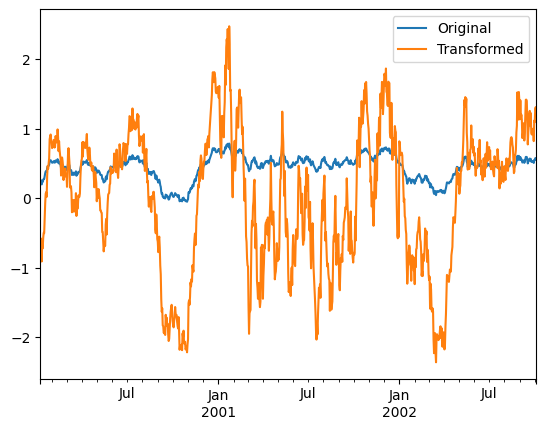

In [284]:
compare = pd.DataFrame({"Original": ts, "Transformed": transformed})
compare.plot()

- Transformation functions that have lower dimension outputs are broadcast to match the shape of the input array.

In [285]:
ts.groupby(lambda x: x.year).transform(lambda x: x.max() - x.min())

2000-01-08    0.770522
2000-01-09    0.770522
2000-01-10    0.770522
2000-01-11    0.770522
2000-01-12    0.770522
                ...   
2002-09-30    0.566252
2002-10-01    0.566252
2002-10-02    0.566252
2002-10-03    0.566252
2002-10-04    0.566252
Freq: D, Length: 1001, dtype: float64

- Another common data transform is to replace missing data with the group mean.

In [286]:
cols = ["A", "B", "C"]
values = np.random.randn(1000, 3)
values[np.random.randint(0, 1000, 100), 0] = np.nan
values[np.random.randint(0, 1000, 50), 1] = np.nan
values[np.random.randint(0, 1000, 200), 2] = np.nan
data_df = pd.DataFrame(values, columns=cols)
data_df

A         B         C
0   -0.115753  0.700864 -0.181698
1    0.609625  1.022724  0.464127
2   -1.974444 -0.312199 -0.662202
3   -0.633727  1.859200 -1.361045
4   -0.543685 -1.072627       NaN
..        ...       ...       ...
995  0.611980  1.061248  1.203102
996  0.984024 -1.323711  0.388496
997 -1.192402 -1.380909 -0.162997
998 -0.247029       NaN  0.988100
999       NaN  0.945702  0.109419

[1000 rows x 3 columns]

In [287]:
countries = np.array(["US", "UK", "GR", "JP"])
key = countries[np.random.randint(0, 4, 1000)]
grouped = data_df.groupby(key)
# Non-NA count in each group
grouped.count()

A    B    C
GR  229  247  202
JP  231  236  206
UK  217  222  200
US  230  246  217

In [288]:
transformed = grouped.transform(lambda x: x.fillna(x.mean()))

- We can verify that the group means have not changed in the transformed data, and that the transformed data contains no NAs.

In [289]:
grouped_trans = transformed.groupby(key)
grouped.mean()  # original group means

A         B         C
GR -0.026442 -0.066001 -0.018331
JP  0.019087  0.076074 -0.088867
UK -0.025602 -0.095396  0.016329
US -0.010998  0.237902 -0.027573

In [290]:
grouped_trans.mean()  # transformation did not change group means

A         B         C
GR -0.026442 -0.066001 -0.018331
JP  0.019087  0.076074 -0.088867
UK -0.025602 -0.095396  0.016329
US -0.010998  0.237902 -0.027573

In [291]:
grouped.count()  # original has some missing data points

A    B    C
GR  229  247  202
JP  231  236  206
UK  217  222  200
US  230  246  217

In [292]:
grouped_trans.count()  # counts after transformation

A    B    C
GR  255  255  255
JP  250  250  250
UK  238  238  238
US  257  257  257

In [293]:
grouped_trans.size()  # Verify non-NA count equals group size

GR    255
JP    250
UK    238
US    257
dtype: int64

- As mentioned in the note above, each of the examples in this section can be computed more efficiently using built-in methods. In the code below, the inefficient way using a UDF is commented out and the faster alternative appears below.

In [295]:
# result = ts.groupby(lambda x: x.year).transform(
#     lambda x: (x - x.mean()) / x.std()
# )
grouped = ts.groupby(lambda x: x.year)
result = (ts - grouped.transform("mean")) / grouped.transform("std")
# result = ts.groupby(lambda x: x.year).transform(lambda x: x.max() - x.min())
grouped = ts.groupby(lambda x: x.year)
result = grouped.transform("max") - grouped.transform("min")

# grouped = data_df.groupby(key)
# result = grouped.transform(lambda x: x.fillna(x.mean()))
grouped = data_df.groupby(key)

result = data_df.fillna(grouped.transform("mean"))

#### Window and resample operations
- It is possible to use resample(), expanding() and rolling() as methods on groupbys.

- The example below will apply the rolling() method on the samples of the column B, based on the groups of column A.

In [296]:
df_re = pd.DataFrame({"A": [1] * 10 + [5] * 10, "B": np.arange(20)})
df_re

A   B
0   1   0
1   1   1
2   1   2
3   1   3
4   1   4
5   1   5
6   1   6
7   1   7
8   1   8
9   1   9
10  5  10
11  5  11
12  5  12
13  5  13
14  5  14
15  5  15
16  5  16
17  5  17
18  5  18
19  5  19

In [297]:
df_re.groupby("A").rolling(4).B.mean()

A    
1  0      NaN
   1      NaN
   2      NaN
   3      1.5
   4      2.5
   5      3.5
   6      4.5
   7      5.5
   8      6.5
   9      7.5
5  10     NaN
   11     NaN
   12     NaN
   13    11.5
   14    12.5
   15    13.5
   16    14.5
   17    15.5
   18    16.5
   19    17.5
Name: B, dtype: float64

- The expanding() method will accumulate a given operation (sum() in the example) for all the members of each particular group.

In [298]:
df_re.groupby("A").expanding().sum()

B
A          
1 0     0.0
  1     1.0
  2     3.0
  3     6.0
  4    10.0
  5    15.0
  6    21.0
  7    28.0
  8    36.0
  9    45.0
5 10   10.0
  11   21.0
  12   33.0
  13   46.0
  14   60.0
  15   75.0
  16   91.0
  17  108.0
  18  126.0
  19  145.0

- Suppose you want to use the resample() method to get a daily frequency in each group of your dataframe, and wish to complete the missing values with the ffill() method.

In [299]:
df_re = pd.DataFrame(
    {
        "date": pd.date_range(start="2016-01-01", periods=4, freq="W"),
        "group": [1, 1, 2, 2],
        "val": [5, 6, 7, 8],
    }
).set_index("date")
df_re

group  val
date                  
2016-01-03      1    5
2016-01-10      1    6
2016-01-17      2    7
2016-01-24      2    8

In [300]:
df_re.groupby("group").resample("1D", include_groups=False).ffill()

val
group date           
1     2016-01-03    5
      2016-01-04    5
      2016-01-05    5
      2016-01-06    5
      2016-01-07    5
      2016-01-08    5
      2016-01-09    5
      2016-01-10    6
2     2016-01-17    7
      2016-01-18    7
      2016-01-19    7
      2016-01-20    7
      2016-01-21    7
      2016-01-22    7
      2016-01-23    7
      2016-01-24    8

#### Filtration
- A filtration is a GroupBy operation that subsets the original grouping object. It may either filter out entire groups, part of groups, or both. Filtrations return a filtered version of the calling object, including the grouping columns when provided. In the following example, class is included in the result.

In [301]:
speeds

class           order  max_speed
falcon     bird   Falconiformes      389.0
parrot     bird  Psittaciformes       24.0
lion     mammal       Carnivora       80.2
monkey   mammal        Primates        NaN
leopard  mammal       Carnivora       58.0

In [302]:
speeds.groupby("class").nth(1)

class           order  max_speed
parrot    bird  Psittaciformes       24.0
monkey  mammal        Primates        NaN

- **Note**: Unlike aggregations, filtrations do not add the group keys to the index of the result. Because of this, passing as_index=False or sort=True will not affect these methods.
- Filtrations will respect subsetting the columns of the GroupBy object.

In [303]:
speeds.groupby("class")[["order", "max_speed"]].nth(1)

order  max_speed
parrot  Psittaciformes       24.0
monkey        Primates        NaN

#### Built-in filtrations
- The following methods on GroupBy act as filtrations. All these methods have an efficient, GroupBy-specific, implementation.

| Method | Description |
| ------ | ----------- |
| head() | Select the top row(s) of each group |
|nth() | Select the nth row(s) of each group |
| tail() | Select the bottom row(s) of each group |

- Users can also use transformations along with Boolean indexing to construct complex filtrations within groups. For example, suppose we are given groups of products and their volumes, and we wish to subset the data to only the largest products capturing no more than 90% of the total volume

In [304]:
product_volumes = pd.DataFrame(
    {
        "group": list("xxxxyyy"),
        "product": list("abcdefg"),
        "volume": [10, 30, 20, 15, 40, 10, 20],
    }
)
product_volumes

group product  volume
0     x       a      10
1     x       b      30
2     x       c      20
3     x       d      15
4     y       e      40
5     y       f      10
6     y       g      20

In [305]:
# Sort by volume to select the largest products first
product_volumes = product_volumes.sort_values("volume", ascending=False)
grouped = product_volumes.groupby("group")["volume"]
cumpct = grouped.cumsum() / grouped.transform("sum")
cumpct

4    0.571429
1    0.400000
2    0.666667
6    0.857143
3    0.866667
0    1.000000
5    1.000000
Name: volume, dtype: float64

In [306]:
significant_products = product_volumes[cumpct <= 0.9]
significant_products.sort_values(["group", "product"])

group product  volume
1     x       b      30
2     x       c      20
3     x       d      15
4     y       e      40
6     y       g      20

#### The filter method
- **Note**: Filtering by supplying filter with a User-Defined Function (UDF) is often less performant than using the built-in methods on GroupBy. Consider breaking up a complex operation into a chain of operations that utilize the built-in methods.

- The filter method takes a User-Defined Function (UDF) that, when applied to an entire group, returns either True or False. The result of the filter method is then the subset of groups for which the UDF returned True.

- Suppose we want to take only elements that belong to groups with a group sum greater than 2.

In [307]:
sf = pd.Series([1, 1, 2, 3, 3, 3])
sf.groupby(sf).filter(lambda x: x.sum() > 2)

3    3
4    3
5    3
dtype: int64

- Another useful operation is filtering out elements that belong to groups with only a couple members.

In [308]:
dff = pd.DataFrame({"A": np.arange(8), "B": list("aabbbbcc")})

dff.groupby("B").filter(lambda x: len(x) > 2)


A  B
2  2  b
3  3  b
4  4  b
5  5  b

- Alternatively, instead of dropping the offending groups, we can return a like-indexed objects where the groups that do not pass the filter are filled with NaNs.

In [309]:
dff.groupby("B").filter(lambda x: len(x) > 2, dropna=False)

A    B
0  NaN  NaN
1  NaN  NaN
2  2.0    b
3  3.0    b
4  4.0    b
5  5.0    b
6  NaN  NaN
7  NaN  NaN

- For DataFrames with multiple columns, filters should explicitly specify a column as the filter criterion.

In [310]:
dff["C"] = np.arange(8)
dff.groupby("B").filter(lambda x: len(x["C"]) > 2)

A  B  C
2  2  b  2
3  3  b  3
4  4  b  4
5  5  b  5

#### Flexible apply
- Some operations on the grouped data might not fit into the aggregation, transformation, or filtration categories. For these, you can use the apply function.
- **Warning**: apply has to try to infer from the result whether it should act as a reducer, transformer, or filter, depending on exactly what is passed to it. Thus the grouped column(s) may be included in the output or not. While it tries to intelligently guess how to behave, it can sometimes guess wrong.

- **Note**: All of the examples in this section can be more reliably, and more efficiently, computed using other pandas functionality.

In [311]:
df

A      B         C         D
0  foo    one  0.694087  0.957327
1  bar    one  0.906515  0.546048
2  foo    two -1.455247 -1.199594
3  bar  three  1.275655 -1.496085
4  foo    two  0.551230 -0.261782
5  bar    two -2.614050 -0.221906
6  foo    one  0.073554 -1.032631
7  foo  three -1.587928  0.298269

In [312]:
grouped = df.groupby("A")
# could also just call .describe()
grouped["C"].apply(lambda x: x.describe())

A         
bar  count    3.000000
     mean    -0.143960
     std      2.147108
     min     -2.614050
     25%     -0.853767
     50%      0.906515
     75%      1.091085
     max      1.275655
foo  count    5.000000
     mean    -0.344861
     std      1.099504
     min     -1.587928
     25%     -1.455247
     50%      0.073554
     75%      0.551230
     max      0.694087
Name: C, dtype: float64

- The dimension of the returned result can also change:

In [313]:
grouped = df.groupby('A')['C']

def f(group):
    return pd.DataFrame({'original': group,
                         'demeaned': group - group.mean()})

grouped.apply(f)


original  demeaned
A                        
bar 1  0.906515  1.050475
    3  1.275655  1.419615
    5 -2.614050 -2.470090
foo 0  0.694087  1.038948
    2 -1.455247 -1.110386
    4  0.551230  0.896091
    6  0.073554  0.418415
    7 -1.587928 -1.243067

- apply on a Series can operate on a returned value from the applied function that is itself a series, and possibly upcast the result to a DataFrame:

In [314]:
def f(x):
    return pd.Series([x, x ** 2], index=["x", "x^2"])

s = pd.Series(np.random.rand(5))
s

0    0.609743
1    0.014743
2    0.872447
3    0.400177
4    0.873768
dtype: float64

In [315]:
s.apply(f)

x       x^2
0  0.609743  0.371787
1  0.014743  0.000217
2  0.872447  0.761164
3  0.400177  0.160142
4  0.873768  0.763470

- Similar to The aggregate() method, the resulting dtype will reflect that of the apply function. If the results from different groups have different dtypes, then a common dtype will be determined in the same way as DataFrame construction.

#### Control grouped column(s) placement with group_keys
- To control whether the grouped column(s) are included in the indices, you can use the argument group_keys which defaults to True. Compare

In [316]:
df.groupby("A", group_keys=True).apply(lambda x: x, include_groups=False)

B         C         D
A                               
bar 1    one  0.906515  0.546048
    3  three  1.275655 -1.496085
    5    two -2.614050 -0.221906
foo 0    one  0.694087  0.957327
    2    two -1.455247 -1.199594
    4    two  0.551230 -0.261782
    6    one  0.073554 -1.032631
    7  three -1.587928  0.298269

- with

In [317]:
df.groupby("A", group_keys=False).apply(lambda x: x, include_groups=False)


B         C         D
0    one  0.694087  0.957327
1    one  0.906515  0.546048
2    two -1.455247 -1.199594
3  three  1.275655 -1.496085
4    two  0.551230 -0.261782
5    two -2.614050 -0.221906
6    one  0.073554 -1.032631
7  three -1.587928  0.298269

#### Numba Accelerated Routines
- If Numba is installed as an optional dependency, the transform and aggregate methods support engine='numba' and engine_kwargs arguments. See enhancing performance with Numba for general usage of the arguments and performance considerations.

- The function signature must start with values, index exactly as the data belonging to each group will be passed into values, and the group index will be passed into index.

- **Warning**: When using engine='numba', there will be no “fall back” behavior internally. The group data and group index will be passed as NumPy arrays to the JITed user defined function, and no alternative execution attempts will be tried.

#### Other userful features
#### Exclusion of non-numeric columns
- Again consider the example DataFrame we've been looking at:

In [318]:
df

A      B         C         D
0  foo    one  0.694087  0.957327
1  bar    one  0.906515  0.546048
2  foo    two -1.455247 -1.199594
3  bar  three  1.275655 -1.496085
4  foo    two  0.551230 -0.261782
5  bar    two -2.614050 -0.221906
6  foo    one  0.073554 -1.032631
7  foo  three -1.587928  0.298269

- Suppose we wish to compute the standard deviation grouped by the A column. There is a slight problem, namely that we don’t care about the data in column B because it is not numeric. You can avoid non-numeric columns by specifying numeric_only=True:

In [319]:
df.groupby("A").std(numeric_only=True)

C         D
A                      
bar  2.147108  1.031471
foo  1.099504  0.904515

- Note that df.groupby('A').colname.std(). is more efficient than df.groupby('A').std().colname. So if the result of an aggregation function is only needed over one column (here colname), it may be filtered before applying the aggregation function.

In [320]:
from decimal import Decimal
df_dec = pd.DataFrame(
    {
        "id": [1, 2, 1, 2],
        "int_column": [1, 2, 3, 4],
        "dec_column": [
            Decimal("0.50"),
            Decimal("0.15"),
            Decimal("0.25"),
            Decimal("0.40"),
        ],
    }
)
df_dec.groupby(["id"])[["dec_column"]].sum()


dec_column
id           
1        0.75
2        0.55

#### Handling of (un)observed Categorical values
- When using a Categorical grouper (as a single grouper, or as part of multiple groupers), the observed keyword controls whether to return a cartesian product of all possible groupers values (observed=False) or only those that are observed groupers (observed=True).

- Show all values:

In [321]:
pd.Series([1, 1, 1]).groupby(
    pd.Categorical(["a", "a", "a"], categories=["a", "b"]), observed=False
).count()

a    3
b    0
dtype: int64

- Show only the observed values:

In [322]:
pd.Series([1, 1, 1]).groupby(
    pd.Categorical(["a", "a", "a"], categories=["a", "b"]), observed=True
).count()

a    3
dtype: int64

- The returned dtype of the grouped will always include all of the categories that were grouped.

In [323]:
s = (
    pd.Series([1, 1, 1])
    .groupby(pd.Categorical(["a", "a", "a"], categories=["a", "b"]), observed=True)
    .count()
)
s.index.dtype

CategoricalDtype(categories=['a', 'b'], ordered=False, categories_dtype=object)

#### NA group handling
- By NA, we are referring to any NA values, including NA, NaN, NaT, and None. If there are any NA values in the grouping key, by default these will be excluded. In other words, any “NA group” will be dropped. You can include NA groups by specifying dropna=False.

In [324]:
df = pd.DataFrame({"key": [1.0, 1.0, np.nan, 2.0, np.nan], "A": [1, 2, 3, 4, 5]})

df

key  A
0  1.0  1
1  1.0  2
2  NaN  3
3  2.0  4
4  NaN  5

In [325]:
df.groupby("key", dropna=True).sum()

A
key   
1.0  3
2.0  4

In [326]:
df.groupby("key", dropna=False).sum()

A
key   
1.0  3
2.0  4
NaN  8

#### Grouping with ordered factors
- Categorical variables represented as instances of pandas’s Categorical class can be used as group keys. If so, the order of the levels will be preserved. When observed=False and sort=False, any unobserved categories will be at the end of the result in order.

In [327]:
days = pd.Categorical(
    values=["Wed", "Mon", "Thu", "Mon", "Wed", "Sat"],
    categories=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
)
data = pd.DataFrame(
   {
       "day": days,
       "workers": [3, 4, 1, 4, 2, 2],
   }
)

data

day  workers
0  Wed        3
1  Mon        4
2  Thu        1
3  Mon        4
4  Wed        2
5  Sat        2

In [328]:
data.groupby("day", observed=False, sort=True).sum()

workers
day         
Mon        8
Tue        0
Wed        5
Thu        1
Fri        0
Sat        2
Sun        0

In [329]:
data.groupby("day", observed=False, sort=False).sum()

workers
day         
Wed        5
Mon        8
Thu        1
Sat        2
Tue        0
Fri        0
Sun        0

#### Grouping with a grouper specification
- You may need to specify a bit more data to properly group. You can use the pd.Grouper to provide this local control.

In [330]:
import datetime

df = pd.DataFrame(
    {
        "Branch": "A A A A A A A B".split(),
        "Buyer": "Carl Mark Carl Carl Joe Joe Joe Carl".split(),
        "Quantity": [1, 3, 5, 1, 8, 1, 9, 3],
        "Date": [
            datetime.datetime(2013, 1, 1, 13, 0),
            datetime.datetime(2013, 1, 1, 13, 5),
            datetime.datetime(2013, 10, 1, 20, 0),
            datetime.datetime(2013, 10, 2, 10, 0),
            datetime.datetime(2013, 10, 1, 20, 0),
            datetime.datetime(2013, 10, 2, 10, 0),
            datetime.datetime(2013, 12, 2, 12, 0),
            datetime.datetime(2013, 12, 2, 14, 0),
        ],
    }
)

df

Branch Buyer  Quantity                Date
0      A  Carl         1 2013-01-01 13:00:00
1      A  Mark         3 2013-01-01 13:05:00
2      A  Carl         5 2013-10-01 20:00:00
3      A  Carl         1 2013-10-02 10:00:00
4      A   Joe         8 2013-10-01 20:00:00
5      A   Joe         1 2013-10-02 10:00:00
6      A   Joe         9 2013-12-02 12:00:00
7      B  Carl         3 2013-12-02 14:00:00

- Groupby a specific column with the desired frequency. This is like resampling.

In [331]:
df.groupby([pd.Grouper(freq="1ME", key="Date"), "Buyer"])[["Quantity"]].sum()


Quantity
Date       Buyer          
2013-01-31 Carl          1
           Mark          3
2013-10-31 Carl          6
           Joe           9
2013-12-31 Carl          3
           Joe           9

- When freq is specified, the object returned by pd.Grouper will be an instance of pandas.api.typing.TimeGrouper. When there is a column and index with the same name, you can use key to group by the column and level to group by the index.

In [332]:
df = df.set_index("Date")
df["Date"] = df.index + pd.offsets.MonthEnd(2)
df.groupby([pd.Grouper(freq="6ME", key="Date"), "Buyer"])[["Quantity"]].sum()


Quantity
Date       Buyer          
2013-02-28 Carl          1
           Mark          3
2014-02-28 Carl          9
           Joe          18

In [333]:
df.groupby([pd.Grouper(freq="6ME", level="Date"), "Buyer"])[["Quantity"]].sum()


Quantity
Date       Buyer          
2013-01-31 Carl          1
           Mark          3
2014-01-31 Carl          9
           Joe          18

#### Taking the first rows of each group
- Just like for a DataFrame or Series you can call head and tail on a groupby:

In [334]:
df = pd.DataFrame([[1, 2], [1, 4], [5, 6]], columns=["A", "B"])
df

A  B
0  1  2
1  1  4
2  5  6

In [335]:
g = df.groupby("A")
g.head(1)

A  B
0  1  2
2  5  6

In [336]:
g.tail(1)

A  B
1  1  4
2  5  6

- This shows the first or last n rows from each group.

#### Taking the nth row of each group
- To select the nth item from each group, use DataFrameGroupBy.nth() or SeriesGroupBy.nth(). Arguments supplied can be any integer, lists of integers, slices, or lists of slices; see below for examples. When the nth element of a group does not exist an error is not raised; instead no corresponding rows are returned.

- In general this operation acts as a filtration. In certain cases it will also return one row per group, making it also a reduction. However because in general it can return zero or multiple rows per group, pandas treats it as a filtration in all cases.

In [337]:
df = pd.DataFrame([[1, np.nan], [1, 4], [5, 6]], columns=["A", "B"])

g = df.groupby("A")
g.nth(0)

A    B
0  1  NaN
2  5  6.0

In [338]:
g.nth(-1)

A    B
1  1  4.0
2  5  6.0

In [339]:
g.nth(1)

A    B
1  1  4.0

- If the nth element of a group does not exist, then no corresponding row is included in the result. In particular, if the specified n is larger than any group, the result will be an empty DataFrame.

In [340]:
g.nth(5)

Empty DataFrame
Columns: [A, B]
Index: []

- If you want to select the nth not-null item, use the dropna kwarg. For a DataFrame this should be either 'any' or 'all' just like you would pass to dropna:

In [341]:
# nth(0) is the same as g.first()
g.nth(0, dropna="any")

A    B
1  1  4.0
2  5  6.0

In [342]:
g.first()

B
A     
1  4.0
5  6.0

In [343]:
# nth(-1) is the same as g.last()
g.nth(-1, dropna="any")

A    B
1  1  4.0
2  5  6.0

In [344]:
g.last()

B
A     
1  4.0
5  6.0

In [345]:
g.B.nth(0, dropna="all")

1    4.0
2    6.0
Name: B, dtype: float64

- You can also select multiple rows from each group by specifying multiple nth values as a list of ints.

In [346]:
business_dates = pd.date_range(start="4/1/2014", end="6/30/2014", freq="B")
df = pd.DataFrame(1, index=business_dates, columns=["a", "b"])

# get the first, 4th, and last date index for each month
df.groupby([df.index.year, df.index.month]).nth([0, 3, -1])


a  b
2014-04-01  1  1
2014-04-04  1  1
2014-04-30  1  1
2014-05-01  1  1
2014-05-06  1  1
2014-05-30  1  1
2014-06-02  1  1
2014-06-05  1  1
2014-06-30  1  1

- You may also use slices or lists of slices.

In [347]:
df.groupby([df.index.year, df.index.month]).nth[1:]

a  b
2014-04-02  1  1
2014-04-03  1  1
2014-04-04  1  1
2014-04-07  1  1
2014-04-08  1  1
...        .. ..
2014-06-24  1  1
2014-06-25  1  1
2014-06-26  1  1
2014-06-27  1  1
2014-06-30  1  1

[62 rows x 2 columns]

In [348]:
df.groupby([df.index.year, df.index.month]).nth[1:, :-1]

a  b
2014-04-01  1  1
2014-04-02  1  1
2014-04-03  1  1
2014-04-04  1  1
2014-04-07  1  1
...        .. ..
2014-06-24  1  1
2014-06-25  1  1
2014-06-26  1  1
2014-06-27  1  1
2014-06-30  1  1

[65 rows x 2 columns]

#### Enumerate group items
- To see the order in which each row appears within its group, use the cumcount method:

In [349]:
dfg = pd.DataFrame(list("aaabba"), columns=["A"])
dfg

A
0  a
1  a
2  a
3  b
4  b
5  a

In [350]:
dfg.groupby("A").cumcount()

0    0
1    1
2    2
3    0
4    1
5    3
dtype: int64

In [351]:
dfg.groupby("A").cumcount(ascending=False)

0    3
1    2
2    1
3    1
4    0
5    0
dtype: int64

#### Enumerate groups
- To see the ordering of the groups (as opposed to the order of rows within a group given by cumcount) you can use DataFrameGroupBy.ngroup().

- **Note**: that the numbers given to the groups match the order in which the groups would be seen when iterating over the groupby object, not the order they are first observed.

In [352]:
dfg = pd.DataFrame(list("aaabba"), columns=["A"])
dfg

A
0  a
1  a
2  a
3  b
4  b
5  a

In [353]:
dfg.groupby("A").ngroup()

0    0
1    0
2    0
3    1
4    1
5    0
dtype: int64

In [354]:
dfg.groupby("A").ngroup(ascending=False)

0    1
1    1
2    1
3    0
4    0
5    1
dtype: int64

#### Plotting
- Groupby also works with some plotting methods. In this case, suppose we suspect that the values in column 1 are 3 times higher on average in group “B”.

In [355]:
np.random.seed(1234)
df = pd.DataFrame(np.random.randn(50, 2))
df["g"] = np.random.choice(["A", "B"], size=50)
df.loc[df["g"] == "B", 1] += 3

- We can easily visualize this with a boxplot:

A         Axes(0.1,0.15;0.363636x0.75)
B    Axes(0.536364,0.15;0.363636x0.75)
dtype: object

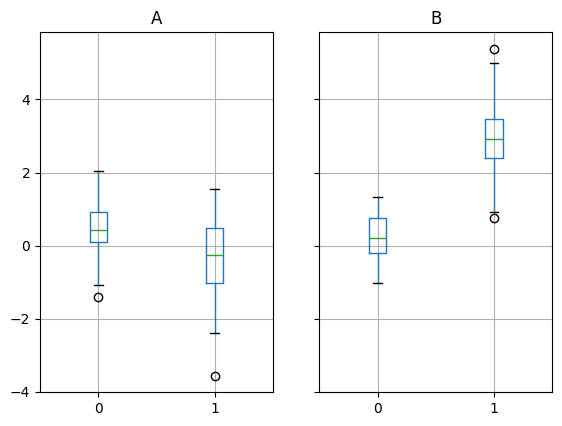

In [356]:
df.groupby("g").boxplot()

- The result of calling boxplot is a dictionary whose keys are the values of our grouping column g (“A” and “B”). The values of the resulting dictionary can be controlled by the return_type keyword of boxplot. See the visualization documentation for more.

- **Warning**: For historical reasons, df.groupby("g").boxplot() is not equivalent to df.boxplot(by="g"). See here for an explanation.

#### Piping function calls
- Similar to the functionality provided by DataFrame and Series, functions that take GroupBy objects can be chained together using a pipe method to allow for a cleaner, more readable syntax. To read about .pipe in general terms, see here.

- Combining .groupby and .pipe is often useful when you need to reuse GroupBy objects.

- As an example, imagine having a DataFrame with columns for stores, products, revenue and quantity sold. We’d like to do a groupwise calculation of prices (i.e. revenue/quantity) per store and per product. We could do this in a multi-step operation, but expressing it in terms of piping can make the code more readable. First we set the data:

In [357]:
n = 1000
df = pd.DataFrame(
    {
        "Store": np.random.choice(["Store_1", "Store_2"], n),
        "Product": np.random.choice(["Product_1", "Product_2"], n),
        "Revenue": (np.random.random(n) * 50 + 10).round(2),
        "Quantity": np.random.randint(1, 10, size=n),
    }
)

df.head(2)

Store    Product  Revenue  Quantity
0  Store_2  Product_1    26.12         1
1  Store_2  Product_1    28.86         1

- We now find the prices per store/product.

In [358]:
(
    df.groupby(["Store", "Product"])
    .pipe(lambda grp: grp.Revenue.sum() / grp.Quantity.sum())
    .unstack()
    .round(2)
)


Product  Product_1  Product_2
Store                        
Store_1       6.82       7.05
Store_2       6.30       6.64

- Piping can also be expressive when you want to deliver a grouped object to some arbitrary function, for example:

In [359]:
def mean(groupby):
    return groupby.mean()

df.groupby(["Store", "Product"]).pipe(mean)

Revenue  Quantity
Store   Product                       
Store_1 Product_1  34.622727  5.075758
        Product_2  35.482815  5.029630
Store_2 Product_1  32.972837  5.237589
        Product_2  34.684360  5.224000

- Here mean takes a GroupBy object and finds the mean of the Revenue and Quantity columns respectively for each Store-Product combination. The mean function can be any function that takes in a GroupBy object; the .pipe will pass the GroupBy object as a parameter into the function you specify.

#### Examples
#### Multi-column factorization
- By using DataFrameGroupBy.ngroup(), we can extract information about the groups in a way similar to factorize() (as described further in the reshaping API) but which applies naturally to multiple columns of mixed type and different sources. This can be useful as an intermediate categorical-like step in processing, when the relationships between the group rows are more important than their content, or as input to an algorithm which only accepts the integer encoding. (For more information about support in pandas for full categorical data, see the Categorical introduction and the API documentation.)

In [360]:
dfg = pd.DataFrame({"A": [1, 1, 2, 3, 2], "B": list("aaaba")})
dfg

A  B
0  1  a
1  1  a
2  2  a
3  3  b
4  2  a

In [361]:
dfg.groupby(["A", "B"]).ngroup()

0    0
1    0
2    1
3    2
4    1
dtype: int64

In [362]:
dfg.groupby(["A", [0, 0, 0, 1, 1]]).ngroup()

0    0
1    0
2    1
3    3
4    2
dtype: int64

#### Groupby by indexer to ‘resample’ data
- Resampling produces new hypothetical samples (resamples) from already existing observed data or from a model that generates data. These new samples are similar to the pre-existing samples.

- In order for resample to work on indices that are non-datetimelike, the following procedure can be utilized.

- In the following examples, df.index // 5 returns an integer array which is used to determine what gets selected for the groupby operation.

- **Note**: The example below shows how we can downsample by consolidation of samples into fewer ones. Here by using df.index // 5, we are aggregating the samples in bins. By applying std() function, we aggregate the information contained in many samples into a small subset of values which is their standard deviation thereby reducing the number of samples.

In [363]:
df = pd.DataFrame(np.random.randn(10, 2))
df

0         1
0 -0.793893  0.321153
1  0.342250  1.618906
2 -0.975807  1.918201
3 -0.810847 -1.405919
4 -1.977759  0.461659
5  0.730057 -1.316938
6 -0.751328  0.528290
7 -0.257759 -1.081009
8  0.505895 -1.701948
9 -1.006349  0.020208

In [364]:
df.index // 5

Index([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype='int64')

In [365]:
df.groupby(df.index //5).std()

0         1
0  0.823647  1.312912
1  0.760109  0.942941

#### Returning a Series to propagate names
- Group DataFrame columns, compute a set of metrics and return a named Series. The Series name is used as the name for the column index. This is especially useful in conjunction with reshaping operations such as stacking, in which the column index name will be used as the name of the inserted column:

In [366]:
df = pd.DataFrame(
    {
        "a": [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2],
        "b": [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        "c": [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
        "d": [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    }
)

def compute_metrics(x):
    result = {"b_sum": x["b"].sum(), "c_mean": x["c"].mean()}
    return pd.Series(result, name="metrics")

result = df.groupby("a").apply(compute_metrics, include_groups=False)

result

metrics  b_sum  c_mean
a                     
0          2.0     0.5
1          2.0     0.5
2          2.0     0.5

In [367]:
result.stack(future_stack=True)

a  metrics
0  b_sum      2.0
   c_mean     0.5
1  b_sum      2.0
   c_mean     0.5
2  b_sum      2.0
   c_mean     0.5
dtype: float64